# Amazon fine food review data analysis
Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

This dataset contain Amazon food review from Oct 1999 - Oct 2012 for nearly 75k products.

### This dataset contains following columns :
  1. Id
  2. ProductId - unique identifier for the product
  3. UserId - uniqiue identifier for the user
  4. ProfileName
  5. HelpfulnessNumerator - number of users who found the review helpful
  6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
  7. Score - rating between 1 and 5
  8. Time - timestamp for the review
  9. Summary - brief summary of the review
  10. Text - text of the review


### Objective :
  Based on given food reviews classify them in two classes i.e. positive and negative.
  
  To achieve above objective we will first try to visualize the data using two columns Score and Text and perform following operations on it.
  1. Data cleaning and transformation
      - Remove duplicate data 
      - Transform Score column value 1-2 to ""negative" and 4-5 to "positive".  
      - Remove html tags, non-English  words, words smaller than 2 alphabets, stop words and special symbols.
      - convert words to lower case and apply stemming,  lemmatization.
      - select 1K data points for each positive and negative class.
  2. vectorize Text column using 
      * Bag Of Word
      * tf-idf
      * Average W2V
      * tf-idf weighted W2V
  3. Visualize review vectors using tsne for different perplexity value.






# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 



In [6]:
import sqlite3
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [2]:
#read data from gdrive into pandas dataframe
#conn = sqlite3.connect('/content/gdrive/My Drive/ColabNotebooks/amazon-fine-food-reviews/database.sqlite')
conn = sqlite3.connect('amazon-fine-food-reviews/database.sqlite')
all_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)

all_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [3]:
#convert all Scores having value 1 or 2 to negative and 4 or 5 to positive.

set_val = {1:"negative",2:"negative",4:"positive",5:"positive"}
all_data = all_data.replace({'Score':set_val})
all_data['Score'] = all_data['Score'].astype('category')
all_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
#sort data based on ProductId column
sorted_data=all_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#reamoving duplicate rows
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [6]:
# Select only those columns whose HelpfulnessDenominator value is greater than HelpfulnessNumerator

final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [7]:
final['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [8]:
#download all english stop words using nltk
import nltk
#nltk.download('stopwords')
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/nanduramchavan_01/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [1]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import pickle
import os
from tqdm import tqdm
import re
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from collections import Counter


In [2]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [3]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stop= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [4]:
#functions to remove special charachers and html tags

#stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [13]:
# removing html tags, punctuation, non english words nad top words

if not os.path.isfile('amazon-fine-food-reviews/final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    word_count=[]
    noun_count=[]
    adj_count=[]
    verb_count=[]
    adverb_count=[]
    s=''
    for sent in tqdm(final['Text'].values):
        filtered_sentence=[]
        sent=cleanhtml(sent) # remove HTMl tags
        sent = re.sub(r"http\S+", "", sent)
        sent = BeautifulSoup(sent, 'lxml').get_text()
        sent = decontracted(sent)
        sent = re.sub("\S*\d\S*", "", sent).strip()
        sent = re.sub('[^A-Za-z]+', ' ', sent)
        #create new features
        words = []
        words = cleanpunc(sent).split()
        word_count.append(len(words))
        #count pos tags
        pos_tags = nltk.pos_tag(words, tagset='universal')
        count = Counter(elem[1] for elem in pos_tags)
        noun_count.append(count["NOUN"])
        adj_count.append(count["ADJ"])
        verb_count.append(count["VERB"])
        adverb_count.append(count["ADV"])
        for cleaned_words in words:
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(wordnet_lemmatizer.lemmatize(cleaned_words.lower(), pos="v")).encode('utf8')
                    #s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
        str1 = b" ".join(filtered_sentence) #final string of cleaned words

        final_string.append(str1)
        i+=1

    #Store data into .sqlite file 
    
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
#     final['TextWordCount'] = word_count
#     final['NounCount'] = noun_count
#     final['AdjCount'] = adj_count
#     final['VerbCount'] = verb_count
#     final['AdverbCount'] = adverb_count
    # store final table into an SQlLite table for future.
    conn = sqlite3.connect('amazon-fine-food-reviews/final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('amazon-fine-food-reviews/positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('amazon-fine-food-reviews/negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

100%|██████████| 364171/364171 [42:18<00:00, 143.43it/s] 


In [4]:
# read cleamed data from previously stored sqlite file

#conn = sqlite3.connect('/content/gdrive/My Drive/ColabNotebooks/amazon-fine-food-reviews/final.sqlite')
conn = sqlite3.connect('amazon-fine-food-reviews/final.sqlite')
  
clean_data = pd.read_sql_query(""" SELECT * FROM Reviews """, conn)
clean_data.columns

Index(['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText', 'TextWordCount', 'NounCount',
       'AdjCount', 'VerbCount', 'AdverbCount'],
      dtype='object')

In [5]:
# sort data by time
type(clean_data)
clean_data = clean_data.sort_values(by='Time', axis=0,ascending=True)
clean_data.tail()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,TextWordCount,NounCount,AdjCount,VerbCount,AdverbCount
139298,511105,552637,B0012EYELE,AWQOTHBNJBSVB,"Gregory E. Grant ""GG""",0,0,negative,1351209600,Couldn't tell you how it tasted,"The bottle was not sealed, and when I opened t...",bottle not seal open cover black crusty stuff ...,24,4,3,6,4
333542,282454,306008,B0058CGLH6,A3QRR5YN6ALFPG,james a riche,0,0,negative,1351209600,If you like Campbells Pepper pot soup then don...,"Not at all like pepper pot soup, it is just a ...",not like pepper pot soup crab soup little flav...,27,9,2,5,3
139690,311138,336872,B0012KB4U2,AGQBI6601XH2R,DaniC,0,0,positive,1351209600,Both cats love these!,They only like this brand and flavor of treat....,like brand flavor treat not soft version one c...,51,11,2,9,4
213087,524273,566798,B001PQTYN2,A3OTHWG8LLCLMU,"PACKERS FAN ""Gordon Boone""",1,1,positive,1351209600,Great,"If you like a great , hot, sauce then buy this...",like great hot sauce buy spicy heat not like n...,24,3,2,6,4
57313,355171,384161,B000EVWQZW,A2PCNXBSKCABG5,Whit,0,0,positive,1351209600,Versatile Mix,This mix makes a good bread or can also be use...,mix make good bread also use make pop overs ne...,40,12,2,9,2


In [6]:
# get 100k clean data points 
final_data = clean_data[:100000].copy()
final_data.shape

(100000, 17)

In [7]:
conn = sqlite3.connect('amazon-fine-food-reviews/sorted_final.sqlite')
c=conn.cursor()
conn.text_factory = str
final_data.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
             index=True, index_label=None, chunksize=None, dtype=None)
conn.close()

In [8]:
final_data['Score'].value_counts()

positive    87729
negative    12271
Name: Score, dtype: int64

In [14]:
import pickle

In [12]:
X_train = final_data["CleanedText"][:60000]
y_train = final_data["Score"][:60000]
X_val = final_data["CleanedText"][60000:80000]
y_val = final_data["Score"][60000:80000]
X_test = final_data["CleanedText"][80000:]
y_test = final_data["Score"][80000:]

In [15]:
with open("amazon-fine-food-reviews/X_train.pkl","wb") as file:
  pickle.dump(X_train, file)
  
with open("amazon-fine-food-reviews/X_test.pkl","wb") as file:
  pickle.dump(X_test, file)

with open("amazon-fine-food-reviews/X_val.pkl","wb") as file:
  pickle.dump(X_val, file)
  
with open("amazon-fine-food-reviews/y_train.pkl","wb") as file:
  pickle.dump(y_train, file)

with open("amazon-fine-food-reviews/y_test.pkl","wb") as file:
  pickle.dump(y_test, file)

with open("amazon-fine-food-reviews/y_val.pkl","wb") as file:
  pickle.dump(y_val, file)


## [3.2] Preprocessing Review Summary


In [15]:
conn = sqlite3.connect('amazon-fine-food-reviews/sorted_final.sqlite')
  
final = pd.read_sql_query(""" SELECT * FROM Reviews """, conn)
final.columns

Index(['level_0', 'index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText', 'TextWordCount', 'NounCount',
       'AdjCount', 'VerbCount', 'AdverbCount'],
      dtype='object')

In [24]:
# removing html tags, punctuation, non english words nad top words

#if not os.path.isfile('amazon-fine-food-reviews/final.sqlite'):
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
word_count=[]
noun_count=[]
adj_count=[]
verb_count=[]
adverb_count=[]
s=''
for sent in tqdm(final['Summary'].values):
    filtered_sentence=[]
    sent=cleanhtml(sent) # remove HTMl tags
    sent = re.sub(r"http\S+", "", sent)
    sent = BeautifulSoup(sent, 'lxml').get_text()
    sent = decontracted(sent)
    sent = re.sub("\S*\d\S*", "", sent).strip()
    sent = re.sub('[^A-Za-z]+', ' ', sent)

    words = []
    words = cleanpunc(sent).split()
    for cleaned_words in words:
        if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
            if(cleaned_words.lower() not in stop):
                s=(wordnet_lemmatizer.lemmatize(cleaned_words.lower(), pos="v")).encode('utf8')
                filtered_sentence.append(s)
                if (final['Score'].values)[i] == 'positive': 
                    all_positive_words.append(s) #list of all words used to describe positive reviews
                if(final['Score'].values)[i] == 'negative':
                    all_negative_words.append(s) #list of all words used to describe negative reviews reviews
            else:
                continue
        else:
            continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words

    final_string.append(str1)
    i+=1

#Store data into .sqlite file 

final['CleanedSummary']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedSummary']=final['CleanedSummary'].str.decode("utf-8")
# store final table into an SQlLite table for future.
conn = sqlite3.connect('amazon-fine-food-reviews/sorted_final_with_summary.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
             index=False, index_label=None, chunksize=None, dtype=None)
conn.close()


with open('amazon-fine-food-reviews/positive_words_Summary.pkl', 'wb') as f:
    pickle.dump(all_positive_words, f)
with open('amazon-fine-food-reviews/negitive_words_Summary.pkl', 'wb') as f:
    pickle.dump(all_negative_words, f)

100%|██████████| 100000/100000 [00:37<00:00, 2646.16it/s]


In [26]:
final.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,TextWordCount,NounCount,AdjCount,VerbCount,AdverbCount,CleanedSummary
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book make son laugh loud recite c...,76,17,9,18,3,every book educational
1,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember see show air television years ago chi...,75,18,3,15,5,whole series great way spend time child


In [30]:
X_train_summary = final["CleanedSummary"][:60000]
X_val_summary = final["CleanedSummary"][60000:80000]
X_test_summary = final["CleanedSummary"][80000:]

In [31]:
print (X_train_summary.shape)
print (X_val_summary.shape)
print (X_test_summary.shape)

(60000,)
(20000,)
(20000,)


In [32]:
with open("amazon-fine-food-reviews/X_train_summary.pkl","wb") as file:
  pickle.dump(X_train_summary, file)
  
with open("amazon-fine-food-reviews/X_test_summary.pkl","wb") as file:
  pickle.dump(X_test_summary, file)

with open("amazon-fine-food-reviews/X_val_summary.pkl","wb") as file:
  pickle.dump(X_val_summary, file)

# [4] Featurization

## [4.1] BAG OF WORDS

In [33]:
from sklearn.feature_extraction.text import CountVectorizer


In [34]:
def cv_fit_trans(data,filename):
    cv = CountVectorizer()
    review_BOW = cv.fit_transform(data.values)
    print("Shape of train BOW matrix : ",review_BOW.shape)
    with open("amazon-fine-food-reviews/bow/"+filename,"wb") as file:
      pickle.dump(review_BOW, file)
    return cv

def cv_transform(cv,data,filename):
    review_BOW = cv.transform(data.values)
    print("Shape of BOW matrix : ",review_BOW.shape)
    with open("amazon-fine-food-reviews/bow/"+filename,"wb") as file:
      pickle.dump(review_BOW, file)

In [18]:
cv = cv_fit_trans(X_train,"BOW_x_train.pkl")
cv_transform(cv,X_val,"BOW_x_val.pkl")
cv_transform(cv,X_test,"BOW_x_test.pkl")

In [35]:
cv = cv_fit_trans(X_train_summary,"BOW_x_train_summary.pkl")
cv_transform(cv,X_val_summary,"BOW_x_val_summary.pkl")
cv_transform(cv,X_test_summary,"BOW_x_test_summary.pkl")

Shape of train BOW matrix :  (60000, 10789)
Shape of BOW matrix :  (20000, 10789)
Shape of BOW matrix :  (20000, 10789)


## [4.2] TF-IDF

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
def tfidf_fit_trans(data,filename):
    tf_idf_model = TfidfVectorizer(ngram_range=(1,2))
    train_review_tf_idf = tf_idf_model.fit_transform(data.values)
    with open("amazon-fine-food-reviews/tfidf/"+filename,"wb") as file:
      pickle.dump(train_review_tf_idf, file)
    return tf_idf_model

def tfidf_transform(tf_idf_model,data,filename):
    review_tf_idf = tf_idf_model.transform(data.values)
    with open("amazon-fine-food-reviews/tfidf/"+filename,"wb") as file:
      pickle.dump(review_tf_idf, file)

In [21]:
model = tfidf_fit_trans(X_train,"tfidf_x_train.pkl")
tfidf_transform(model,X_val,"tfidf_x_val.pkl")
tfidf_transform(model,X_test,"tfidf_x_test.pkl")

In [38]:
model = tfidf_fit_trans(X_train_summary,"tfidf_x_train_summary.pkl")
tfidf_transform(model,X_val_summary,"tfidf_x_val_summary.pkl")
tfidf_transform(model,X_test_summary,"tfidf_x_test_summary.pkl")

## [4.3.1] Converting text into vectors using Avg W2V, TFIDF-W2V

### [4.3.1.1] Avg W2v

In [22]:
!pip install gensim

/bin/sh: 1: pip: not found


In [39]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import numpy as np
from tqdm import tqdm

In [40]:
train_list_of_sent=[]
val_list_of_sent=[]
test_list_of_sent=[]

In [ ]:
# extract review text sentences
for sent in X_train.values:   #extract train and test sentences to apply created w2v model
    train_list_of_sent.append(sent.split())
for sent in X_val.values:
    val_list_of_sent.append(sent.split())
for sent in X_test.values:
    test_list_of_sent.append(sent.split())

In [41]:
# extract summary sentences
for sent in X_train_summary.values:   #extract train and test sentences to apply created w2v model
    train_list_of_sent.append(sent.split())
for sent in X_val_summary.values:
    val_list_of_sent.append(sent.split())
for sent in X_test_summary.values:
    test_list_of_sent.append(sent.split())

In [42]:
#train data avg w2v
w2v_model=Word2Vec(train_list_of_sent,min_count=5,size=50, workers=4) #min_count-word should have min this many count to be included in w2v, size- n X 50
w2v_words = list(w2v_model.wv.vocab)

In [43]:
def avg_w2v(data,filename):
    # average Word2Vec
    # compute average word2vec for each review.
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(data): # for each tain review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    with open("amazon-fine-food-reviews/avg_w2v/"+filename,"wb") as file:
      pickle.dump(sent_vectors, file)

In [27]:
# call for text
sent_list = [train_list_of_sent,test_list_of_sent,val_list_of_sent]
filenames = ["avg_w2v_x_train.pkl","avg_w2v_x_test.pkl","avg_w2v_x_val.pkl"]
for idx in range(len(sent_list)):
  avg_w2v(sent_list[idx],filenames[idx])

In [44]:
#call for summary
sent_list = [train_list_of_sent,test_list_of_sent,val_list_of_sent]
filenames = ["avg_w2v_x_train_summary.pkl","avg_w2v_x_test_summary.pkl","avg_w2v_x_val_summary.pkl"]
for idx in range(len(sent_list)):
  avg_w2v(sent_list[idx],filenames[idx])

100%|██████████| 20000/20000 [00:01<00:00, 14093.28it/s]


### [4.3.1.2] TFIDF weighted W2v

In [32]:
#for review text
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train.values) #create tfidf matrix on all data
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [46]:
# for summary text
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train_summary.values) #create tfidf matrix on all data
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [48]:
def tf_idf_w2v(sen_list,filename):
  # TF-IDF weighted Word2Vec
  tfidf_feat = model.get_feature_names() # tfidf words/col-names
  # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

  tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
  row=0;

  for sent in tqdm(sen_list): # for each review/sentence 
      sent_vec = np.zeros(50) # as word vectors are of zero length
      weight_sum =0; # num of words with a valid vector in the sentence/review
      for word in sent: # for each word in a review/sentence
          if word in w2v_words:
              vec = w2v_model.wv[word]
              tf_idf = dictionary[word]*(sent.count(word)/len(sent))
              sent_vec += (vec * tf_idf)
              weight_sum += tf_idf
      if weight_sum != 0:
          sent_vec /= weight_sum
      tfidf_sent_vectors.append(sent_vec)
      row += 1

  with open("amazon-fine-food-reviews/tfidf_w2v/"+filename,"wb") as file:
    pickle.dump(tfidf_sent_vectors, file)

In [34]:
sent_list = [train_list_of_sent,test_list_of_sent,val_list_of_sent]
filenames = ["tfidf_w2v_x_train.pkl","tfidf_w2v_x_test.pkl","tfidf_w2v_x_val.pkl"]
for idx in range(len(sent_list)):
  tf_idf_w2v(sent_list[idx],filenames[idx])

100%|██████████| 20000/20000 [00:55<00:00, 358.64it/s]


In [49]:
sent_list = [train_list_of_sent,test_list_of_sent,val_list_of_sent]
filenames = ["tfidf_w2v_x_train_summary.pkl","tfidf_w2v_x_test_summary.pkl","tfidf_w2v_x_val_summary.pkl"]
for idx in range(len(sent_list)):
  tf_idf_w2v(sent_list[idx],filenames[idx])

100%|██████████| 20000/20000 [00:01<00:00, 10703.28it/s]


# Applying SVM

# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

#### [5.1.1.1] Applying Linear SVM on BOW with penalty L1 ,<font color='red'> SET 1</font>

In [29]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from scipy.sparse import coo_matrix, hstack
from scipy.sparse.csr import csr_matrix
import sqlite3
import pandas as pd
from sklearn.linear_model import SGDClassifier
from math import log10

In [30]:
# reading BOW vectors stored in pickle file and related lables
import pickle
# read review text
with open("amazon-fine-food-reviews/bow/BOW_x_train.pkl","rb") as file:
  x_train = pickle.load(file) 
  
with open("amazon-fine-food-reviews/bow/BOW_x_val.pkl","rb") as file:
  x_val = pickle.load(file)
  
with open("amazon-fine-food-reviews/bow/BOW_x_test.pkl","rb") as file:
  x_test = pickle.load(file)

# read summary text
with open("amazon-fine-food-reviews/bow/BOW_x_train_summary.pkl","rb") as file:
  x_train_summary = pickle.load(file) 
  
with open("amazon-fine-food-reviews/bow/BOW_x_val_summary.pkl","rb") as file:
  x_val_summary = pickle.load(file)
  
with open("amazon-fine-food-reviews/bow/BOW_x_test_summary.pkl","rb") as file:
  x_test_summary = pickle.load(file)

#read lables
with open("amazon-fine-food-reviews/y_train.pkl","rb") as file:
  y_train = pickle.load(file)
  y_train = [1 if x=='positive' else 0 for x in y_train]
with open("amazon-fine-food-reviews/y_test.pkl","rb") as file:
  y_test = pickle.load(file)
  y_test = [1 if x=='positive' else 0 for x in y_test]
with open("amazon-fine-food-reviews/y_val.pkl","rb") as file:
  y_val = pickle.load(file)  
  y_val = [1 if x=='positive' else 0 for x in y_val]


In [31]:
# merge text and summary vectors
x_train = hstack([x_train, x_train_summary])
x_val = hstack([x_val, x_val_summary])
x_test = hstack([x_test, x_test_summary])

In [32]:
#np.arange(1e-05,1e+05,1000)
alpha = 10.**np.arange(-5, 6)
alpha = list(alpha)
alpha

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]

In [34]:
# empty list that will hold cv scores
cv_scores = []
train_fpr = dict()
train_tpr = dict()
val_fpr = dict()
val_tpr = dict()
train_auc = []
val_auc = []
# perform  cross validation
for k in tqdm(alpha):
    clf = SGDClassifier(alpha=k , shuffle=False,  n_jobs= 6, penalty='l1', max_iter=1000, tol=1e-3)
    clf.fit(x_train,y_train)
    #predict probabilities for train and validation    
    train_pred_prob = clf.decision_function(x_train)
    #print(train_pred_prob.shape)
    val_pred_prob = clf.decision_function(x_val)
    # train AUC
    train_fpr[k], train_tpr[k], _ = roc_curve(y_train, train_pred_prob,pos_label = 1)
    train_auc.append(auc(train_fpr[k], train_tpr[k]))
    # validation AUC
    val_fpr[k], val_tpr[k], _ = roc_curve(y_val, val_pred_prob,pos_label = 1)
    val_auc.append(auc(val_fpr[k], val_tpr[k]))

100%|██████████| 11/11 [00:14<00:00,  1.66it/s]


In [35]:
# finding best K with cross validation
print("K with maximum score in cross validation : {0}, max validation AUC :{1}".format(alpha[val_auc.index(max(val_auc))],max(val_auc)))


K with maximum score in cross validation : 1e-05, max validation AUC :0.9322403176831795


In [36]:
# apply log function to alpha value to display on graph as these are bigger values  
print(alpha)
alp = list(map(log10,alpha)) 
print(alp)

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]
[-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


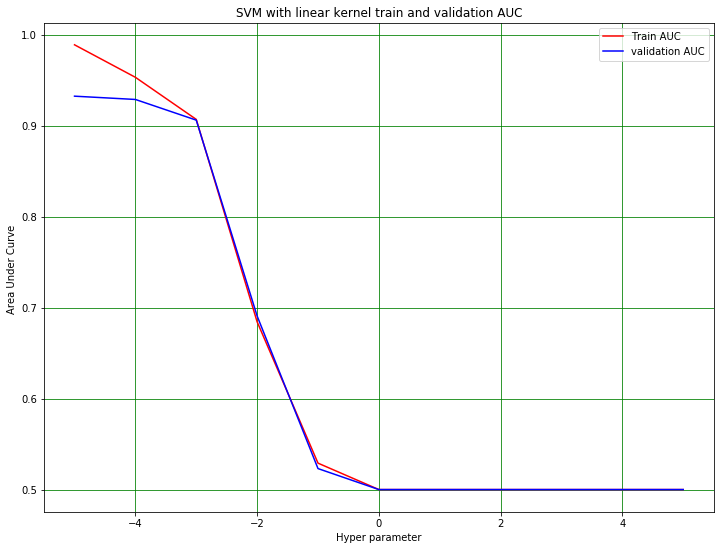

In [37]:
# AUC graph for data with extra features
plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under Curve ')
plt.title('SVM with linear kernel train and validation AUC')
plt.plot(alp,train_auc, color='red', label='Train AUC')
plt.plot(alp,val_auc, color='blue', label='validation AUC')
plt.legend(loc="upper right")
plt.show() 

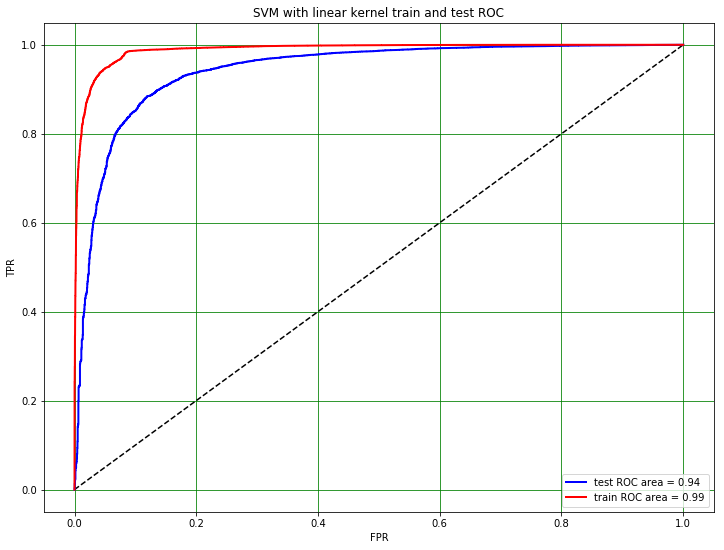

In [38]:
k = alpha[val_auc.index(max(val_auc))]
clf = SGDClassifier(alpha=k , shuffle=False,  n_jobs= 6, penalty='l1', max_iter=1000, tol=1e-3)
clf.fit(x_train,y_train)
test_pred_prob = clf.decision_function(x_test)

# test AUC
test_fpr, test_tpr, _ = roc_curve(y_test, test_pred_prob,pos_label = 1)
test_auc = auc(test_fpr, test_tpr)
plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('SVM with linear kernel train and test ROC')
plt.plot(test_fpr, test_tpr, color='blue', lw=2, label='test ROC area = %0.2f' % test_auc)
plt.plot(train_fpr[k], train_tpr[k], color='red', lw=2, label='train ROC area = %0.2f' % train_auc[alpha.index(k)])
plt.legend(loc="lower right")
plt.show()

### Train confusion matrix

In [39]:
train_pred = clf.predict(x_train)
conf_matrix = confusion_matrix(y_train, train_pred)
report = classification_report(y_train, train_pred)
print("report\n",report)
 

report
               precision    recall  f1-score   support

           0       0.77      0.85      0.81      6853
           1       0.98      0.97      0.97     53147

   micro avg       0.95      0.95      0.95     60000
   macro avg       0.88      0.91      0.89     60000
weighted avg       0.96      0.95      0.95     60000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

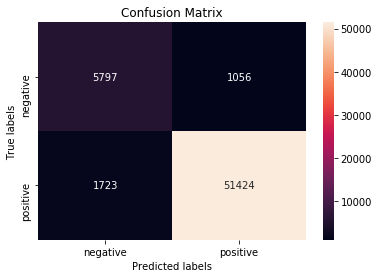

In [40]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

### test confusion matrix

In [41]:
test_pred = clf.predict(x_test)
conf_matrix = confusion_matrix(y_test, test_pred)
report = classification_report(y_test, test_pred)
print("report\n",report)

report
               precision    recall  f1-score   support

           0       0.70      0.76      0.73      2678
           1       0.96      0.95      0.96     17322

   micro avg       0.92      0.92      0.92     20000
   macro avg       0.83      0.86      0.84     20000
weighted avg       0.93      0.92      0.93     20000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

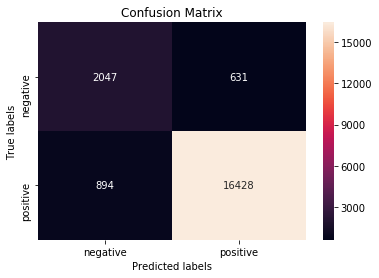

In [42]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

#### [5.1.1.2] Applying Linear SVM on BOW with penalty L2,<font color='red'> SET 1</font>

In [43]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from scipy.sparse import coo_matrix, hstack
from scipy.sparse.csr import csr_matrix
import sqlite3
import pandas as pd
from sklearn.linear_model import SGDClassifier
from math import log10

In [44]:
# reading BOW vectors stored in pickle file and related lables
import pickle
# read review text
with open("amazon-fine-food-reviews/bow/BOW_x_train.pkl","rb") as file:
  x_train = pickle.load(file) 
  
with open("amazon-fine-food-reviews/bow/BOW_x_val.pkl","rb") as file:
  x_val = pickle.load(file)
  
with open("amazon-fine-food-reviews/bow/BOW_x_test.pkl","rb") as file:
  x_test = pickle.load(file)

# read summary text
with open("amazon-fine-food-reviews/bow/BOW_x_train_summary.pkl","rb") as file:
  x_train_summary = pickle.load(file) 
  
with open("amazon-fine-food-reviews/bow/BOW_x_val_summary.pkl","rb") as file:
  x_val_summary = pickle.load(file)
  
with open("amazon-fine-food-reviews/bow/BOW_x_test_summary.pkl","rb") as file:
  x_test_summary = pickle.load(file)

#read lables
with open("amazon-fine-food-reviews/y_train.pkl","rb") as file:
  y_train = pickle.load(file)
  y_train = [1 if x=='positive' else 0 for x in y_train]
with open("amazon-fine-food-reviews/y_test.pkl","rb") as file:
  y_test = pickle.load(file)
  y_test = [1 if x=='positive' else 0 for x in y_test]
with open("amazon-fine-food-reviews/y_val.pkl","rb") as file:
  y_val = pickle.load(file)  
  y_val = [1 if x=='positive' else 0 for x in y_val]


In [45]:
# merge text and summary vectors
x_train = hstack([x_train, x_train_summary])
x_val = hstack([x_val, x_val_summary])
x_test = hstack([x_test, x_test_summary])

In [46]:
#np.arange(1e-05,1e+05,1000)
alpha = 10.**np.arange(-5, 6)
alpha = list(alpha)
alpha

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]

In [47]:
# empty list that will hold cv scores
cv_scores = []
train_fpr = dict()
train_tpr = dict()
val_fpr = dict()
val_tpr = dict()
train_auc = []
val_auc = []
# perform  cross validation
for k in tqdm(alpha):
    clf = SGDClassifier(alpha=k , shuffle=False,  n_jobs= 6, penalty='l2', max_iter=1000, tol=1e-3)
    clf.fit(x_train,y_train)
    #predict probabilities for train and validation    
    train_pred_prob = clf.decision_function(x_train)
    #print(train_pred_prob.shape)
    val_pred_prob = clf.decision_function(x_val)
    # train AUC
    train_fpr[k], train_tpr[k], _ = roc_curve(y_train, train_pred_prob,pos_label = 1)
    train_auc.append(auc(train_fpr[k], train_tpr[k]))
    # validation AUC
    val_fpr[k], val_tpr[k], _ = roc_curve(y_val, val_pred_prob,pos_label = 1)
    val_auc.append(auc(val_fpr[k], val_tpr[k]))

100%|██████████| 11/11 [00:03<00:00,  3.17it/s]


In [48]:
# finding best K with cross validation
print("K with maximum score in cross validation : {0}, max validation AUC :{1}".format(alpha[val_auc.index(max(val_auc))],max(val_auc)))


K with maximum score in cross validation : 0.001, max validation AUC :0.9569300246974144


In [49]:
# apply log function to alpha value to display on graph as these are bigger values  
print(alpha)
alp = list(map(log10,alpha)) 
print(alp)

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]
[-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


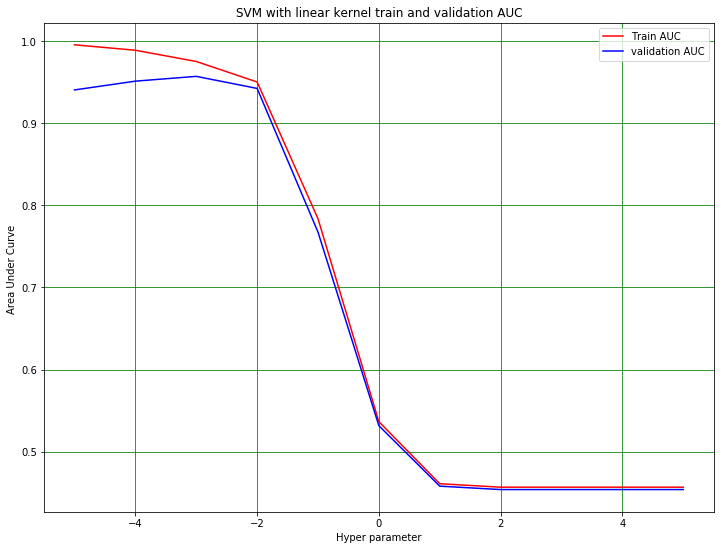

In [50]:
# AUC graph for data with extra features
plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under Curve ')
plt.title('SVM with linear kernel train and validation AUC')
plt.plot(alp,train_auc, color='red', label='Train AUC')
plt.plot(alp,val_auc, color='blue', label='validation AUC')
plt.legend(loc="upper right")
plt.show() 

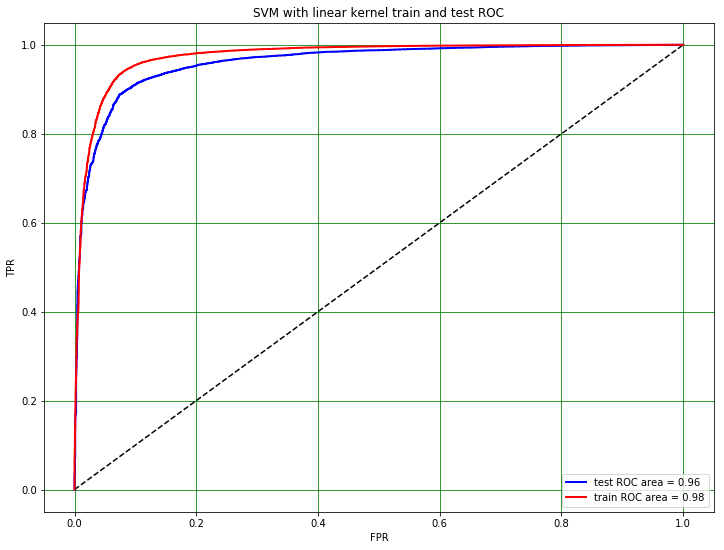

In [51]:
k = alpha[val_auc.index(max(val_auc))]
clf = SGDClassifier(alpha=k , shuffle=False,  n_jobs= 6, penalty='l2', max_iter=1000, tol=1e-3)
clf.fit(x_train,y_train)
test_pred_prob = clf.decision_function(x_test)

# test AUC
test_fpr, test_tpr, _ = roc_curve(y_test, test_pred_prob,pos_label = 1)
test_auc = auc(test_fpr, test_tpr)
plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('SVM with linear kernel train and test ROC')
plt.plot(test_fpr, test_tpr, color='blue', lw=2, label='test ROC area = %0.2f' % test_auc)
plt.plot(train_fpr[k], train_tpr[k], color='red', lw=2, label='train ROC area = %0.2f' % train_auc[alpha.index(k)])
plt.legend(loc="lower right")
plt.show()

### Train confusion matrix

In [52]:
train_pred = clf.predict(x_train)
conf_matrix = confusion_matrix(y_train, train_pred)
report = classification_report(y_train, train_pred)
print("report\n",report)
 

report
               precision    recall  f1-score   support

           0       0.91      0.67      0.77      6853
           1       0.96      0.99      0.97     53147

   micro avg       0.95      0.95      0.95     60000
   macro avg       0.93      0.83      0.87     60000
weighted avg       0.95      0.95      0.95     60000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

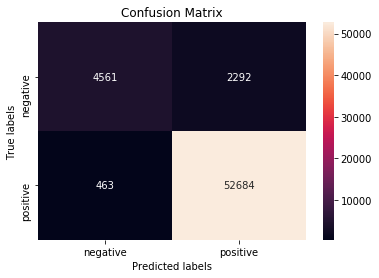

In [53]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

### test confusion matrix

In [54]:
test_pred = clf.predict(x_test)
conf_matrix = confusion_matrix(y_test, test_pred)
report = classification_report(y_test, test_pred)
print("report\n",report)

report
               precision    recall  f1-score   support

           0       0.83      0.63      0.71      2678
           1       0.94      0.98      0.96     17322

   micro avg       0.93      0.93      0.93     20000
   macro avg       0.89      0.80      0.84     20000
weighted avg       0.93      0.93      0.93     20000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

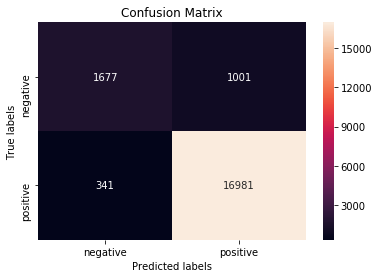

In [55]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

Observation:<br>
    SVM using TFIDF vectorizer with L1 regularizer false positives rate for negative class is greater than L2 regularizer as there are many misclassification for negative class. SVM with L2 regularizer performed better while classifying negative classes.  

### [5.1.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [56]:
conn = sqlite3.connect('amazon-fine-food-reviews/sorted_final_with_summary.sqlite')
  
final = pd.read_sql_query(""" SELECT * FROM Reviews """, conn)
final.columns

Index(['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText', 'TextWordCount', 'NounCount',
       'AdjCount', 'VerbCount', 'AdverbCount', 'CleanedSummary'],
      dtype='object')

In [57]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
review_BOW = cv.fit_transform(final["CleanedText"][:60000].values)
text_features = cv.get_feature_names()
cv = CountVectorizer()
review_BOW = cv.fit_transform(final["CleanedSummary"][:60000].values)
summary_features = cv.get_feature_names()

In [58]:
features = text_features.copy()
features.extend(summary_features)

In [60]:
#code reference : https://stackoverflow.com/questions/29867367/sklearn-multinomial-nb-most-informative-features 
def get_top10(feature_names, clf, class_labels,i):
    """Prints features with the highest coefficient values, per class"""
    #get last 10 probabilities as function sorts it in ascending order 
    top10 = np.argsort(clf.coef_ [0])[-10:]
    print("{0:20} : {1:20}".format(class_labels[i]+" words","log probabilities"))
    #inverse these list of index and pass it to loop so we'll get result in descending order
    for j,index in enumerate(top10[::-1]):
        print("{0:20} : {1:20}".format(feature_names[index],np.sort(clf.coef_[0])[::-1][j])) 

In [61]:
get_top10(features,clf,["negative","positive"],1)

positive words       : log probabilities   
great                :   0.6129662029148071
best                 :   0.6022541721842549
excellent            :   0.5796398850864275
delicious            :    0.545123341621321
love                 :     0.53441131089077
yummy                :   0.5117970237929428
tasty                :   0.5106067981562156
delicious            :  0.47847070596456576
amaze                :  0.45942709577692104
good                 :  0.45823687014019476


#### [5.1.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [62]:
#code reference : https://stackoverflow.com/questions/29867367/sklearn-multinomial-nb-most-informative-features 
def get_top10(feature_names, clf, class_labels,i):
    """Prints features with the highest coefficient values, per class"""
    #get last 10 probabilities as function sorts it in ascending order 
    top10 = np.argsort(clf.coef_ [0])[:10]
    print("{0:20} : {1:20}".format(class_labels[i]+" words","log probabilities"))
    #inverse these list of index and pass it to loop so we'll get result in descending order
    for j,index in enumerate(top10[::-1]):
        print("{0:20} : {1:20}".format(feature_names[index],np.sort(clf.coef_[0])[::-1][j])) 


In [63]:
get_top10(features,clf,["negative","positive"],0)

negative words       : log probabilities   
disappointment       :   0.6129662029148071
awful                :   0.6022541721842549
disappoint           :   0.5796398850864275
awful                :    0.545123341621321
horrible             :     0.53441131089077
terrible             :   0.5117970237929428
yuck                 :   0.5106067981562156
worst                :  0.47847070596456576
not                  :  0.45942709577692104
disappoint           :  0.45823687014019476


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

#### [5.1.2.1] Applying Linear SVM on TFIDF with penalty L1,<font color='red'> SET 2</font>

In [64]:
# read TFIDF vectors stored in pickle file and related lables
import pickle
with open("amazon-fine-food-reviews/tfidf/tfidf_x_train.pkl","rb") as file:
  x_train = pickle.load(file)

with open("amazon-fine-food-reviews/tfidf/tfidf_x_val.pkl","rb") as file:
  x_val = pickle.load(file)
  
with open("amazon-fine-food-reviews/tfidf/tfidf_x_test.pkl","rb") as file:
  x_test = pickle.load(file)


with open("amazon-fine-food-reviews/tfidf/tfidf_x_train_summary.pkl","rb") as file:
  train_summary = pickle.load(file)

with open("amazon-fine-food-reviews/tfidf/tfidf_x_val_summary.pkl","rb") as file:
  val_summary = pickle.load(file)
  
with open("amazon-fine-food-reviews/tfidf/tfidf_x_test_summary.pkl","rb") as file:
  test_summary = pickle.load(file)

with open("amazon-fine-food-reviews/y_train.pkl","rb") as file:
  y_train = pickle.load(file)
  y_train = [1 if x=='positive' else 0 for x in y_train]
with open("amazon-fine-food-reviews/y_test.pkl","rb") as file:
  y_test = pickle.load(file)
  y_test = [1 if x=='positive' else 0 for x in y_test]
with open("amazon-fine-food-reviews/y_val.pkl","rb") as file:
  y_val = pickle.load(file)  
  y_val = [1 if x=='positive' else 0 for x in y_val]

In [65]:
# merge text and summary vectors
x_train = hstack([x_train, train_summary])
x_val = hstack([x_val, val_summary])
x_test = hstack([x_test, test_summary])

In [66]:
#np.arange(1e-05,1e+05,1000)
alpha = 10.**np.arange(-5, 6)
alpha = list(alpha)
alpha

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]

In [67]:
# empty list that will hold cv scores
cv_scores = []
train_fpr = dict()
train_tpr = dict()
val_fpr = dict()
val_tpr = dict()
train_auc = []
val_auc = []
# perform  cross validation
for k in tqdm(alpha):
    clf = SGDClassifier(alpha=k , shuffle=False,  n_jobs= 6, penalty='l1', max_iter=1000, tol=1e-3)
    clf.fit(x_train,y_train)
    #predict probabilities for train and validation    
    train_pred_prob = clf.decision_function(x_train)
    val_pred_prob = clf.decision_function(x_val)
    # train AUC
    train_fpr[k], train_tpr[k], _ = roc_curve(y_train, train_pred_prob,pos_label = 1)
    train_auc.append(auc(train_fpr[k], train_tpr[k]))
    # validation AUC
    val_fpr[k], val_tpr[k], _ = roc_curve(y_val, val_pred_prob,pos_label = 1)
    val_auc.append(auc(val_fpr[k], val_tpr[k]))

100%|██████████| 11/11 [00:21<00:00,  1.67s/it]


In [68]:
# finding best K with cross validation
print("K with maximum score in cross validation : {0}, max validation AUC :{1}".format(alpha[val_auc.index(max(val_auc))],max(val_auc)))


K with maximum score in cross validation : 1e-05, max validation AUC :0.9685305884243558


In [69]:
# apply log function to alpha value to display on graph as these are bigger values  
print(alpha)
alp = list(map(log10,alpha)) 
print(alp)

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]
[-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


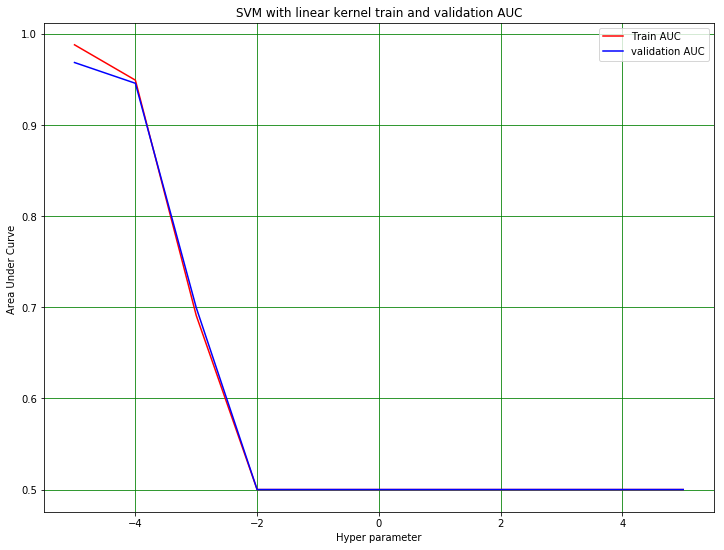

In [70]:
# AUC graph for data with extra features
plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under Curve ')
plt.title('SVM with linear kernel train and validation AUC')
plt.plot(alp,train_auc, color='red', label='Train AUC')
plt.plot(alp,val_auc, color='blue', label='validation AUC')
plt.legend(loc="upper right")
plt.show() 

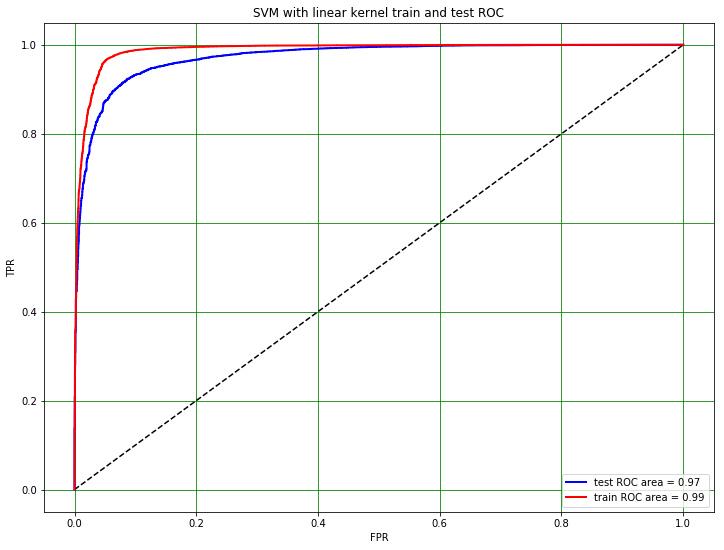

In [71]:
k = alpha[val_auc.index(max(val_auc))]
clf = SGDClassifier(alpha=k , shuffle=False,  n_jobs= 6, penalty='l1', max_iter=1000, tol=1e-3)
clf.fit(x_train,y_train)
test_pred_prob = clf.decision_function(x_test)

# test AUC
test_fpr, test_tpr, _ = roc_curve(y_test, test_pred_prob,pos_label = 1)
test_auc = auc(test_fpr, test_tpr)
plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('SVM with linear kernel train and test ROC')
plt.plot(test_fpr, test_tpr, color='blue', lw=2, label='test ROC area = %0.2f' % test_auc)
plt.plot(train_fpr[k], train_tpr[k], color='red', lw=2, label='train ROC area = %0.2f' % train_auc[alpha.index(k)])
plt.legend(loc="lower right")
plt.show()

### Train confusion matrix

In [72]:
train_pred = clf.predict(x_train)
conf_matrix = confusion_matrix(y_train, train_pred)
report = classification_report(y_train, train_pred)
print("report\n",report)
 

report
               precision    recall  f1-score   support

           0       0.93      0.87      0.90      6853
           1       0.98      0.99      0.99     53147

   micro avg       0.98      0.98      0.98     60000
   macro avg       0.96      0.93      0.94     60000
weighted avg       0.98      0.98      0.98     60000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

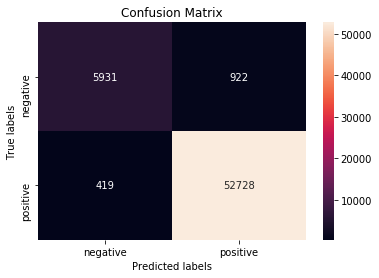

In [73]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

### test confusion matrix

In [74]:
test_pred = clf.predict(x_test)
conf_matrix = confusion_matrix(y_test, test_pred)
report = classification_report(y_test, test_pred)
print("report\n",report)

report
               precision    recall  f1-score   support

           0       0.81      0.78      0.79      2678
           1       0.97      0.97      0.97     17322

   micro avg       0.95      0.95      0.95     20000
   macro avg       0.89      0.88      0.88     20000
weighted avg       0.94      0.95      0.95     20000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

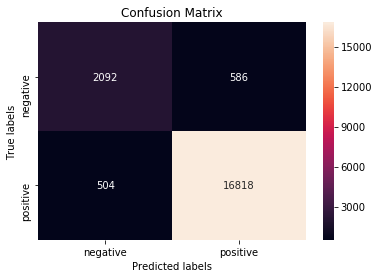

In [75]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

#### [5.1.2.2] Applying Linear SVM on TFIDF with penalty L2,<font color='red'> SET 2</font>

In [77]:
# read TFIDF vectors stored in pickle file and related lables
import pickle
with open("amazon-fine-food-reviews/tfidf/tfidf_x_train.pkl","rb") as file:
  x_train = pickle.load(file)

with open("amazon-fine-food-reviews/tfidf/tfidf_x_val.pkl","rb") as file:
  x_val = pickle.load(file)
  
with open("amazon-fine-food-reviews/tfidf/tfidf_x_test.pkl","rb") as file:
  x_test = pickle.load(file)


with open("amazon-fine-food-reviews/tfidf/tfidf_x_train_summary.pkl","rb") as file:
  train_summary = pickle.load(file)

with open("amazon-fine-food-reviews/tfidf/tfidf_x_val_summary.pkl","rb") as file:
  val_summary = pickle.load(file)
  
with open("amazon-fine-food-reviews/tfidf/tfidf_x_test_summary.pkl","rb") as file:
  test_summary = pickle.load(file)

with open("amazon-fine-food-reviews/y_train.pkl","rb") as file:
  y_train = pickle.load(file)
  y_train = [1 if x=='positive' else 0 for x in y_train]
with open("amazon-fine-food-reviews/y_test.pkl","rb") as file:
  y_test = pickle.load(file)
  y_test = [1 if x=='positive' else 0 for x in y_test]
with open("amazon-fine-food-reviews/y_val.pkl","rb") as file:
  y_val = pickle.load(file)  
  y_val = [1 if x=='positive' else 0 for x in y_val]

In [78]:
# merge text and summary vectors
x_train = hstack([x_train, train_summary])
x_val = hstack([x_val, val_summary])
x_test = hstack([x_test, test_summary])

In [79]:
#np.arange(1e-05,1e+05,1000)
alpha = 10.**np.arange(-5, 6)
alpha = list(alpha)
alpha

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]

In [80]:
# empty list that will hold cv scores
cv_scores = []
train_fpr = dict()
train_tpr = dict()
val_fpr = dict()
val_tpr = dict()
train_auc = []
val_auc = []
# perform  cross validation
for k in tqdm(alpha):
    clf = SGDClassifier(alpha=k , shuffle=False,  n_jobs= 6, penalty='l2', max_iter=1000, tol=1e-3)
    clf.fit(x_train,y_train)
    #predict probabilities for train and validation    
    train_pred_prob = clf.decision_function(x_train)
    val_pred_prob = clf.decision_function(x_val)
    # train AUC
    train_fpr[k], train_tpr[k], _ = roc_curve(y_train, train_pred_prob,pos_label = 1)
    train_auc.append(auc(train_fpr[k], train_tpr[k]))
    # validation AUC
    val_fpr[k], val_tpr[k], _ = roc_curve(y_val, val_pred_prob,pos_label = 1)
    val_auc.append(auc(val_fpr[k], val_tpr[k]))

100%|██████████| 11/11 [00:11<00:00,  1.07it/s]


In [81]:
# finding best K with cross validation
print("K with maximum score in cross validation : {0}, max validation AUC :{1}".format(alpha[val_auc.index(max(val_auc))],max(val_auc)))


K with maximum score in cross validation : 1e-05, max validation AUC :0.9745275350796323


In [82]:
# apply log function to alpha value to display on graph as these are bigger values  
print(alpha)
alp = list(map(log10,alpha)) 
print(alp)

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]
[-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


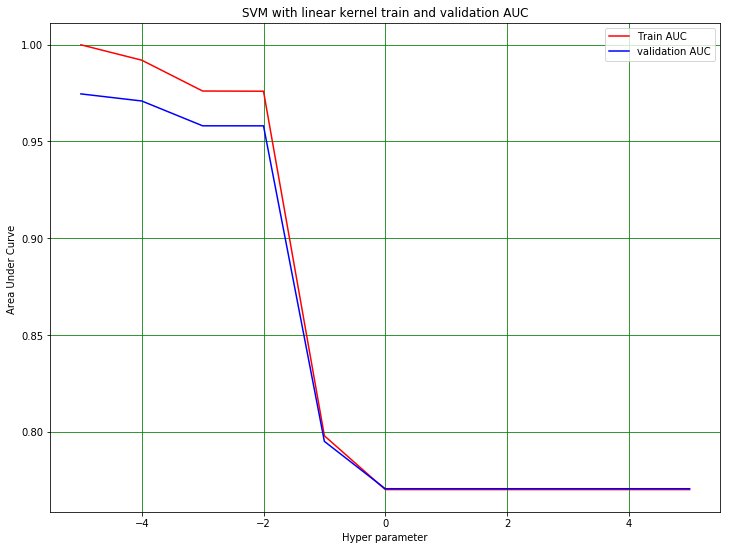

In [83]:
# AUC graph for data with extra features
plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under Curve ')
plt.title('SVM with linear kernel train and validation AUC')
plt.plot(alp,train_auc, color='red', label='Train AUC')
plt.plot(alp,val_auc, color='blue', label='validation AUC')
plt.legend(loc="upper right")
plt.show() 

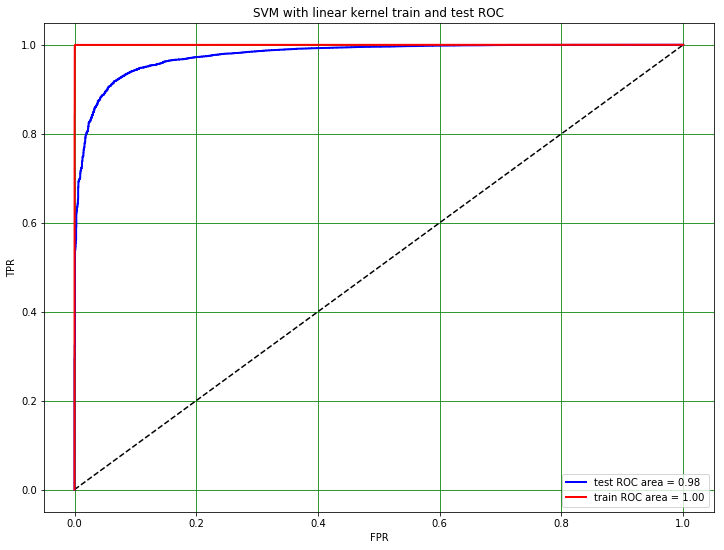

In [84]:
k = alpha[val_auc.index(max(val_auc))]
clf = SGDClassifier(alpha=k , shuffle=False,  n_jobs= 6, penalty='l2', max_iter=1000, tol=1e-3)
clf.fit(x_train,y_train)
test_pred_prob = clf.decision_function(x_test)

# test AUC
test_fpr, test_tpr, _ = roc_curve(y_test, test_pred_prob,pos_label = 1)
test_auc = auc(test_fpr, test_tpr)
plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('SVM with linear kernel train and test ROC')
plt.plot(test_fpr, test_tpr, color='blue', lw=2, label='test ROC area = %0.2f' % test_auc)
plt.plot(train_fpr[k], train_tpr[k], color='red', lw=2, label='train ROC area = %0.2f' % train_auc[alpha.index(k)])
plt.legend(loc="lower right")
plt.show()

### Train confusion matrix

In [85]:
train_pred = clf.predict(x_train)
conf_matrix = confusion_matrix(y_train, train_pred)
report = classification_report(y_train, train_pred)
print("report\n",report)
 

report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6853
           1       1.00      1.00      1.00     53147

   micro avg       1.00      1.00      1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

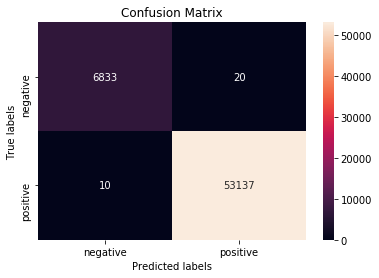

In [86]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

### test confusion matrix

In [87]:
test_pred = clf.predict(x_test)
conf_matrix = confusion_matrix(y_test, test_pred)
report = classification_report(y_test, test_pred)
print("report\n",report)

report
               precision    recall  f1-score   support

           0       0.83      0.78      0.80      2678
           1       0.97      0.98      0.97     17322

   micro avg       0.95      0.95      0.95     20000
   macro avg       0.90      0.88      0.89     20000
weighted avg       0.95      0.95      0.95     20000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

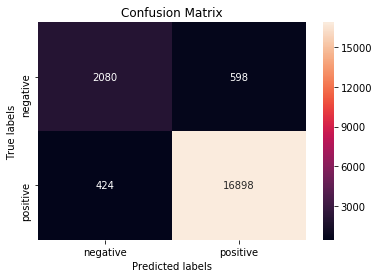

In [88]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

Observation :<br>
    Linear SVM with L1 regularizer have 0.79 and 0.97 F1 scores and L2 have 0.8 and 0.97 for both classes, both performed similar good but SVM with L2 regularizer able to identify some negative classes correctly. 

### [5.1.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.1.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [89]:
conn = sqlite3.connect('amazon-fine-food-reviews/sorted_final_with_summary.sqlite')
  
final = pd.read_sql_query(""" SELECT * FROM Reviews """, conn)
final.columns

Index(['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText', 'TextWordCount', 'NounCount',
       'AdjCount', 'VerbCount', 'AdverbCount', 'CleanedSummary'],
      dtype='object')

In [90]:
def get_tfidf_top10(features, clf, class_labels,i):
    """Prints features with the highest coefficient values, per class"""
    top10 = np.argsort(clf.coef_[0])[-10:]
    print("{0:20} : {1:20}".format(class_labels[i]+" words","log probabilities"))
    for j,index in enumerate(top10[::-1]):
        print("{0:20} : {1:20}".format(features[index],np.sort(clf.coef_[0])[::-1][j]))

In [91]:
text_features = []
summary_features= []
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_model = TfidfVectorizer(ngram_range=(1,2))
train_review_tf_idf = tf_idf_model.fit_transform(final["CleanedText"][:60000].values)
text_features = tf_idf_model.get_feature_names()

tf_idf_model = TfidfVectorizer(ngram_range=(1,2))
train_summary_tf_idf = tf_idf_model.fit_transform(final["CleanedSummary"][:60000].values)
summary_features = tf_idf_model.get_feature_names()

In [92]:
features = text_features.copy()
features.extend(summary_features)

In [93]:
get_tfidf_top10(features,clf,["negative","positive"],1)

positive words       : log probabilities   
great                :    4.585318955924148
delicious            :   3.7972863293755075
best                 :   3.5813682182856357
not bad              :    3.495150342900715
love                 :   3.4886514686886927
good                 :    3.320362625535132
excellent            :    3.304478258624059
great                :   3.1259440518017514
not disappoint       :     3.00270030634442
perfect              :     2.86948938176282


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [94]:
def get_tfidf_top10(features, clf, class_labels,i):
    """Prints features with the highest coefficient values, per class"""
    top10 = np.argsort(clf.coef_[0])[:10]
    print("{0:20} : {1:20}".format(class_labels[i]+" words","log probabilities"))
    for j,index in enumerate(top10[::-1]):
        print("{0:20} : {1:20}".format(features[index],np.sort(clf.coef_[0])[::-1][j]))

In [95]:
get_tfidf_top10(features,clf,["negative","positive"],0)

negative words       : log probabilities   
terrible             :    4.585318955924148
worst                :   3.7972863293755075
disappointment       :   3.5813682182856357
not recommend        :    3.495150342900715
unfortunately        :   3.4886514686886927
not                  :    3.320362625535132
not                  :    3.304478258624059
worst                :   3.1259440518017514
not worth            :     3.00270030634442
disappoint           :     2.86948938176282


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [59]:
# read BOW vectors stored in pickle file and related lables
import pickle
with open("amazon-fine-food-reviews/avg_w2v/avg_w2v_x_train.pkl","rb") as file:
  x_train = pickle.load(file)

with open("amazon-fine-food-reviews/avg_w2v/avg_w2v_x_val.pkl","rb") as file:
  x_val = pickle.load(file)
  
with open("amazon-fine-food-reviews/avg_w2v/avg_w2v_x_test.pkl","rb") as file:
  x_test = pickle.load(file)

with open("amazon-fine-food-reviews/avg_w2v/avg_w2v_x_train_summary.pkl","rb") as file:
  train_summary = pickle.load(file)

with open("amazon-fine-food-reviews/avg_w2v/avg_w2v_x_val_summary.pkl","rb") as file:
  val_summary = pickle.load(file)
  
with open("amazon-fine-food-reviews/avg_w2v/avg_w2v_x_test_summary.pkl","rb") as file:
  test_summary = pickle.load(file)

with open("amazon-fine-food-reviews/y_train.pkl","rb") as file:
  y_train = pickle.load(file)
  y_train = [1 if x=='positive' else 0 for x in y_train]
with open("amazon-fine-food-reviews/y_test.pkl","rb") as file:
  y_test = pickle.load(file)
  y_test = [1 if x=='positive' else 0 for x in y_test]
with open("amazon-fine-food-reviews/y_val.pkl","rb") as file:
  y_val = pickle.load(file)  
  y_val = [1 if x=='positive' else 0 for x in y_val]

In [60]:
# merge text and summary vectors
x_train =[np.concatenate((x,train_summary[idx])) for idx,x in enumerate(x_train)]
x_val = [np.concatenate((x,val_summary[idx])) for idx,x in enumerate(x_val)]
x_test = [np.concatenate((x,test_summary[idx])) for idx,x in enumerate(x_test)]

In [61]:
#np.arange(1e-05,1e+05,1000)
alpha = 10.**np.arange(-5, 6)
alpha = list(alpha)
alpha

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]

In [62]:
# empty list that will hold cv scores
cv_scores = []
train_fpr = dict()
train_tpr = dict()
val_fpr = dict()
val_tpr = dict()
train_auc = []
val_auc = []
# perform  cross validation
for k in tqdm(alpha):
    clf = SGDClassifier(alpha=k , shuffle=False,  n_jobs= 6, max_iter=1000, tol=1e-3)
    clf.fit(x_train,y_train)
    #predict probabilities for train and validation    
    train_pred_prob = clf.decision_function(x_train)
    val_pred_prob = clf.decision_function(x_val)
    # train AUC
    train_fpr[k], train_tpr[k], _ = roc_curve(y_train, train_pred_prob,pos_label = 1)
    train_auc.append(auc(train_fpr[k], train_tpr[k]))
    # validation AUC
    val_fpr[k], val_tpr[k], _ = roc_curve(y_val, val_pred_prob,pos_label = 1)
    val_auc.append(auc(val_fpr[k], val_tpr[k]))

100%|██████████| 11/11 [00:04<00:00,  2.54it/s]


In [63]:
# finding best K with cross validation
print("K with maximum score in cross validation : {0}, max validation AUC :{1}".format(alpha[val_auc.index(max(val_auc))],max(val_auc)))


K with maximum score in cross validation : 0.0001, max validation AUC :0.9358156490260592


In [64]:
# apply log function to alpha value to display on graph as these are bigger values  
print(alpha)
alp = list(map(log10,alpha)) 
print(alp)

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]
[-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


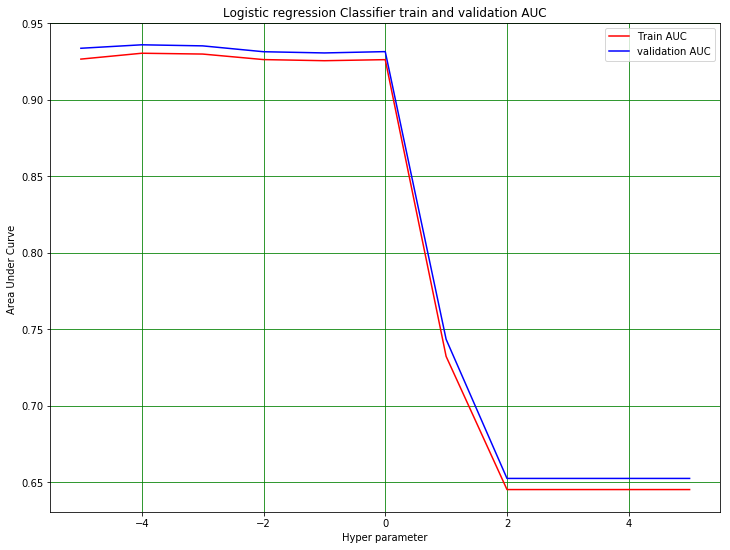

In [65]:
# AUC graph for data with extra features
plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under Curve ')
plt.title('SVM with linear kernel train and validation AUC')
plt.plot(alp,train_auc, color='red', label='Train AUC')
plt.plot(alp,val_auc, color='blue', label='validation AUC')
plt.legend(loc="upper right")
plt.show() 

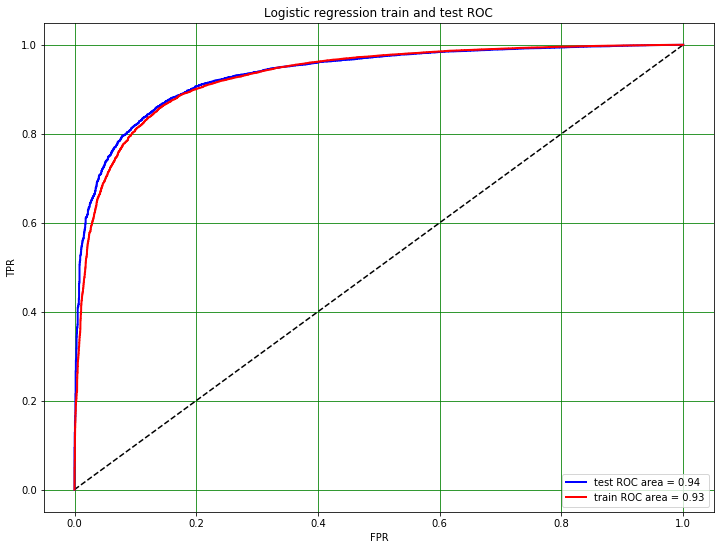

In [66]:
k = alpha[val_auc.index(max(val_auc))]
clf = SGDClassifier(alpha=k , shuffle=False,  n_jobs= 6, max_iter=1000, tol=1e-3)
clf.fit(x_train,y_train)
test_pred_prob = clf.decision_function(x_test)

# test AUC
test_fpr, test_tpr, _ = roc_curve(y_test, test_pred_prob,pos_label = 1)
test_auc = auc(test_fpr, test_tpr)
plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('SVM with linear kernel train and test ROC')
plt.plot(test_fpr, test_tpr, color='blue', lw=2, label='test ROC area = %0.2f' % test_auc)
plt.plot(train_fpr[k], train_tpr[k], color='red', lw=2, label='train ROC area = %0.2f' % train_auc[alpha.index(k)])
plt.legend(loc="lower right")
plt.show()

### Train confusion matrix

In [67]:
train_pred = clf.predict(x_train)
conf_matrix = confusion_matrix(y_train, train_pred)
report = classification_report(y_train, train_pred)
print("report\n",report)
 

report
               precision    recall  f1-score   support

           0       0.66      0.62      0.64      6853
           1       0.95      0.96      0.95     53147

   micro avg       0.92      0.92      0.92     60000
   macro avg       0.80      0.79      0.80     60000
weighted avg       0.92      0.92      0.92     60000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

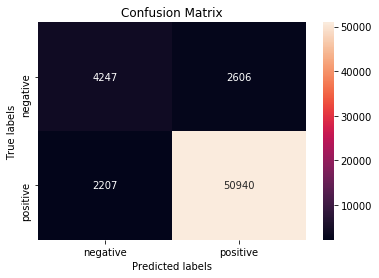

In [68]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

### test confusion matrix

In [69]:
test_pred = clf.predict(x_test)
conf_matrix = confusion_matrix(y_test, test_pred)
report = classification_report(y_test, test_pred)
print("report\n",report)

report
               precision    recall  f1-score   support

           0       0.68      0.64      0.66      2678
           1       0.94      0.95      0.95     17322

   micro avg       0.91      0.91      0.91     20000
   macro avg       0.81      0.80      0.80     20000
weighted avg       0.91      0.91      0.91     20000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

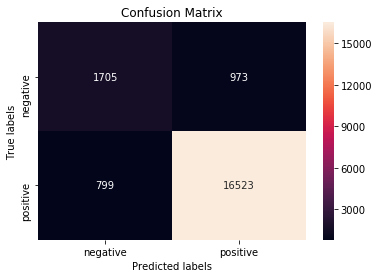

In [70]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [45]:
import pickle
with open("amazon-fine-food-reviews/tfidf_w2v/tfidf_w2v_x_train.pkl","rb") as file:
  x_train = pickle.load(file)

with open("amazon-fine-food-reviews/tfidf_w2v/tfidf_w2v_x_val.pkl","rb") as file:
  x_val = pickle.load(file)
  
with open("amazon-fine-food-reviews/tfidf_w2v/tfidf_w2v_x_test.pkl","rb") as file:
  x_test = pickle.load(file)

with open("amazon-fine-food-reviews/tfidf_w2v/tfidf_w2v_x_train_summary.pkl","rb") as file:
  train_summary = pickle.load(file)

with open("amazon-fine-food-reviews/tfidf_w2v/tfidf_w2v_x_val_summary.pkl","rb") as file:
  val_summary = pickle.load(file)
  
with open("amazon-fine-food-reviews/tfidf_w2v/tfidf_w2v_x_test_summary.pkl","rb") as file:
  test_summary = pickle.load(file)

with open("amazon-fine-food-reviews/y_train.pkl","rb") as file:
  y_train = pickle.load(file)
  y_train = [1 if x=='positive' else 0 for x in y_train]
with open("amazon-fine-food-reviews/y_test.pkl","rb") as file:
  y_test = pickle.load(file)
  y_test = [1 if x=='positive' else 0 for x in y_test]
with open("amazon-fine-food-reviews/y_val.pkl","rb") as file:
  y_val = pickle.load(file)  
  y_val = [1 if x=='positive' else 0 for x in y_val]

In [46]:
# merge text and summary vectors
x_train =[np.concatenate((x,train_summary[idx])) for idx,x in enumerate(x_train)]
x_val = [np.concatenate((x,val_summary[idx])) for idx,x in enumerate(x_val)]
x_test = [np.concatenate((x,test_summary[idx])) for idx,x in enumerate(x_test)]

In [47]:
#np.arange(1e-05,1e+05,1000)
alpha = 10.**np.arange(-5, 6)
alpha = list(alpha)
alpha

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]

In [50]:
# empty list that will hold cv scores
cv_scores = []
train_fpr = dict()
train_tpr = dict()
val_fpr = dict()
val_tpr = dict()
train_auc = []
val_auc = []
# perform  cross validation
for k in tqdm(alpha):
    clf = SGDClassifier(alpha=k , shuffle=False,  n_jobs= 6, max_iter=1000, tol=1e-3)
    clf.fit(x_train,y_train)
    #predict probabilities for train and validation    
    train_pred_prob = clf.decision_function(x_train)
    val_pred_prob = clf.decision_function(x_val)
    # train AUC
    train_fpr[k], train_tpr[k], _ = roc_curve(y_train, train_pred_prob,pos_label = 1)
    train_auc.append(auc(train_fpr[k], train_tpr[k]))
    # validation AUC
    val_fpr[k], val_tpr[k], _ = roc_curve(y_val, val_pred_prob,pos_label = 1)
    val_auc.append(auc(val_fpr[k], val_tpr[k]))

100%|██████████| 11/11 [00:05<00:00,  2.50it/s]


In [51]:
# finding best K with cross validation
print("K with maximum score in cross validation : {0}, max validation AUC :{1}".format(alpha[val_auc.index(max(val_auc))],max(val_auc)))


K with maximum score in cross validation : 0.0001, max validation AUC :0.9201294499750489


In [52]:
# apply log function to alpha value to display on graph as these are bigger values  
print(alpha)
alp = list(map(log10,alpha)) 
print(alp)

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]
[-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


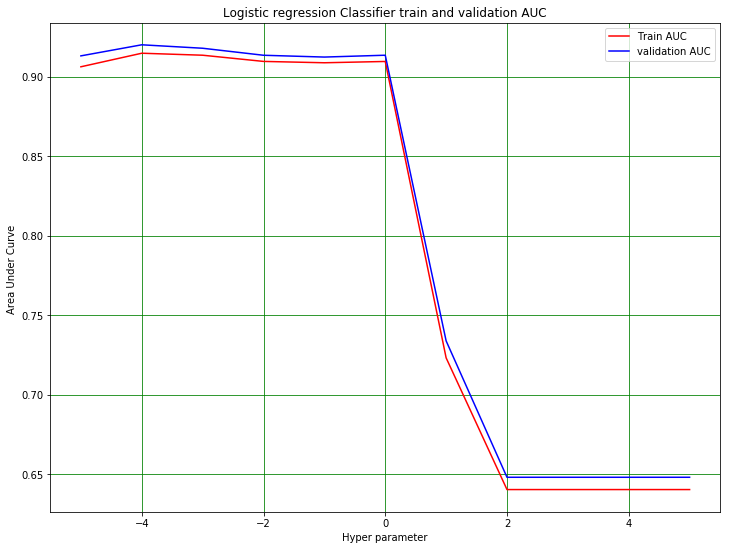

In [53]:
# AUC graph for data with extra features
plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under Curve ')
plt.title('SVM with linear kernel train and validation AUC')
plt.plot(alp,train_auc, color='red', label='Train AUC')
plt.plot(alp,val_auc, color='blue', label='validation AUC')
plt.legend(loc="upper right")
plt.show() 

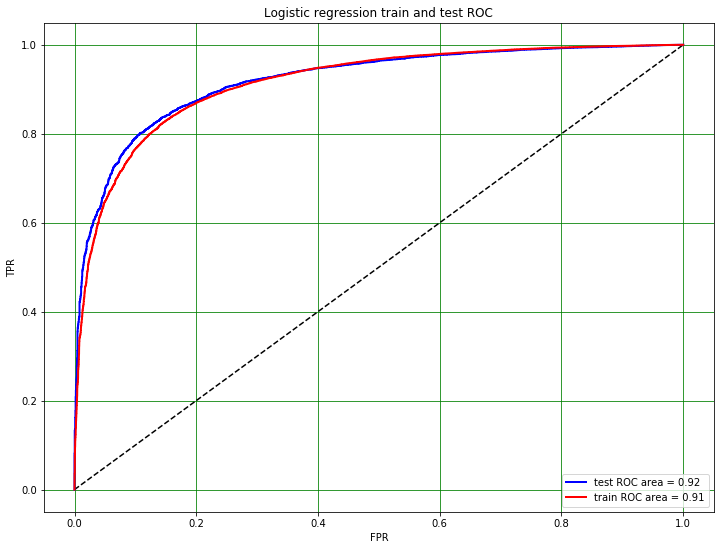

In [54]:
k = alpha[val_auc.index(max(val_auc))]
clf =  SGDClassifier(alpha=k , shuffle=False,  n_jobs= 6, max_iter=1000, tol=1e-3)
clf.fit(x_train,y_train)
test_pred_prob = clf.decision_function(x_test)

# test AUC
test_fpr, test_tpr, _ = roc_curve(y_test, test_pred_prob,pos_label = 1)
test_auc = auc(test_fpr, test_tpr)
plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('SVM with linear kernel train and test ROC')
plt.plot(test_fpr, test_tpr, color='blue', lw=2, label='test ROC area = %0.2f' % test_auc)
plt.plot(train_fpr[k], train_tpr[k], color='red', lw=2, label='train ROC area = %0.2f' % train_auc[alpha.index(k)])
plt.legend(loc="lower right")
plt.show()

### Train confusion matrix

In [55]:
train_pred = clf.predict(x_train)
conf_matrix = confusion_matrix(y_train, train_pred)
report = classification_report(y_train, train_pred)
print("report\n",report)
 

report
               precision    recall  f1-score   support

           0       0.66      0.51      0.58      6853
           1       0.94      0.97      0.95     53147

   micro avg       0.91      0.91      0.91     60000
   macro avg       0.80      0.74      0.76     60000
weighted avg       0.91      0.91      0.91     60000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

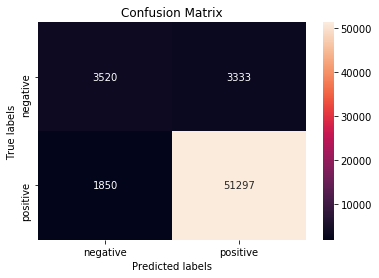

In [56]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

### test confusion matrix

In [57]:
test_pred = clf.predict(x_test)
conf_matrix = confusion_matrix(y_test, test_pred)
report = classification_report(y_test, test_pred)
print("report\n",report)

report
               precision    recall  f1-score   support

           0       0.67      0.52      0.59      2678
           1       0.93      0.96      0.94     17322

   micro avg       0.90      0.90      0.90     20000
   macro avg       0.80      0.74      0.77     20000
weighted avg       0.89      0.90      0.90     20000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

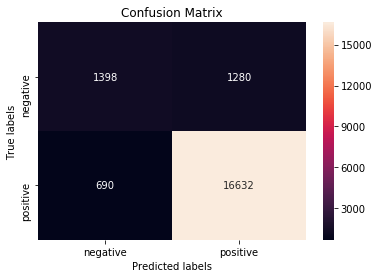

In [58]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [1]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from scipy.sparse import coo_matrix, hstack
from scipy.sparse.csr import csr_matrix
import sqlite3
import pandas as pd
from sklearn.svm import SVC
from math import log10
import pickle

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
import pickle

In [3]:
with open("amazon-fine-food-reviews/X_train.pkl","rb") as file:
  X_train = pickle.load(file)
  
with open("amazon-fine-food-reviews/X_test.pkl","rb") as file:
  X_test = pickle.load(file)

with open("amazon-fine-food-reviews/X_val.pkl","rb") as file:
  X_val = pickle.load(file)

In [4]:
cv = CountVectorizer(min_df=10, max_features=500)
x_train = cv.fit_transform(X_train.values[:24000])
print("Shape of train BOW matrix : ",x_train.shape)
x_val = cv.transform(X_val.values[:8000])
print("Shape of val BOW matrix : ",x_val.shape)
x_test = cv.transform(X_test.values[:8000])
print("Shape of test BOW matrix : ",x_test.shape)

Shape of train BOW matrix :  (24000, 500)
Shape of val BOW matrix :  (8000, 500)
Shape of test BOW matrix :  (8000, 500)


In [5]:
with open("amazon-fine-food-reviews/X_train_summary.pkl","rb") as file:
  X_train_summary = pickle.load(file)
  
with open("amazon-fine-food-reviews/X_test_summary.pkl","rb") as file:
  X_test_summary = pickle.load(file)

with open("amazon-fine-food-reviews/X_val_summary.pkl","rb") as file:
  X_val_summary = pickle.load(file)

In [6]:
cv = CountVectorizer(min_df=10, max_features=500)
x_train_summary = cv.fit_transform(X_train_summary.values[:24000])
print("Shape of train BOW matrix : ",x_train_summary.shape)
x_val_summary = cv.transform(X_val_summary.values[:8000])
print("Shape of test BOW matrix : ",x_val_summary.shape)
x_test_summary = cv.transform(X_test_summary.values[:8000])
print("Shape of test BOW matrix : ",x_test_summary.shape)

Shape of train BOW matrix :  (24000, 500)
Shape of test BOW matrix :  (8000, 500)
Shape of test BOW matrix :  (8000, 500)


In [7]:
#read lables
with open("amazon-fine-food-reviews/y_train.pkl","rb") as file:
  y_train = pickle.load(file)
  y_train = [1 if x=='positive' else 0 for x in y_train[:24000]]
with open("amazon-fine-food-reviews/y_test.pkl","rb") as file:
  y_test = pickle.load(file)
  y_test = [1 if x=='positive' else 0 for x in y_test[:8000]]
with open("amazon-fine-food-reviews/y_val.pkl","rb") as file:
  y_val = pickle.load(file)  
  y_val = [1 if x=='positive' else 0 for x in y_val[:8000]]

In [8]:
# merge text and summary vectors
x_train = hstack([x_train, x_train_summary])
x_val = hstack([x_val, x_val_summary])
x_test = hstack([x_test, x_test_summary])

In [9]:
#np.arange(1e-05,1e+05,1000)
alpha = 10.**np.arange(-5, 6)
alpha = list(alpha)
alpha

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]

In [10]:
# empty list that will hold cv scores
cv_scores = []
train_fpr = dict()
train_tpr = dict()
val_fpr = dict()
val_tpr = dict()
train_auc = []
val_auc = []
# perform  cross validation
for k in tqdm(alpha):
    clf = SVC(C=k, kernel='rbf', class_weight='balanced',gamma='auto')
    clf.fit(x_train,y_train)
    #predict probabilities for train and validation    
    train_pred_prob = clf.decision_function(x_train)
    #print(train_pred_prob.shape)
    val_pred_prob = clf.decision_function(x_val)
    # train AUC
    train_fpr[k], train_tpr[k], _ = roc_curve(y_train, train_pred_prob,pos_label = 1)
    train_auc.append(auc(train_fpr[k], train_tpr[k]))
    # validation AUC
    val_fpr[k], val_tpr[k], _ = roc_curve(y_val, val_pred_prob,pos_label = 1)
    val_auc.append(auc(val_fpr[k], val_tpr[k]))

100%|██████████| 11/11 [53:44<00:00, 301.78s/it]


In [11]:
# finding best K with cross validation
print("K with maximum score in cross validation : {0}, max validation AUC :{1}".format(alpha[val_auc.index(max(val_auc))],max(val_auc)))


K with maximum score in cross validation : 10.0, max validation AUC :0.9341224656020325


In [12]:
# apply log function to alpha value to display on graph as these are bigger values  
print(alpha)
alp = list(map(log10,alpha)) 
print(alp)

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]
[-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


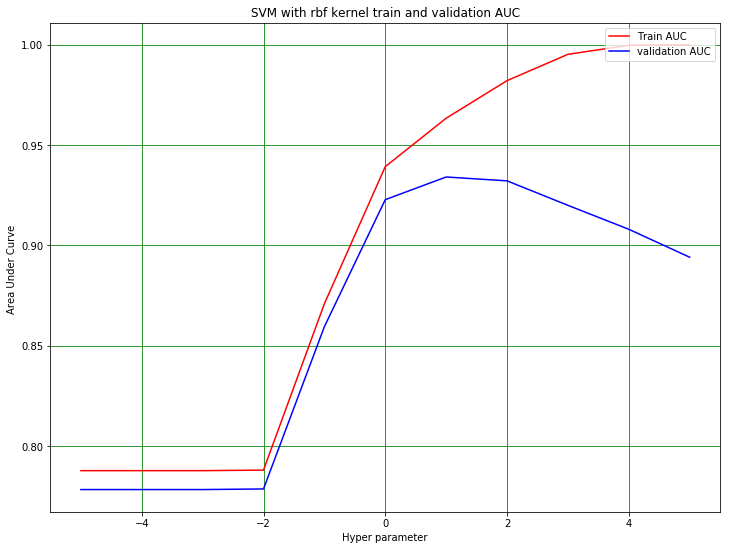

In [13]:
# AUC graph for data with extra features
plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under Curve ')
plt.title('SVM with rbf kernel train and validation AUC')
plt.plot(alp,train_auc, color='red', label='Train AUC')
plt.plot(alp,val_auc, color='blue', label='validation AUC')
plt.legend(loc="upper right")
plt.show() 

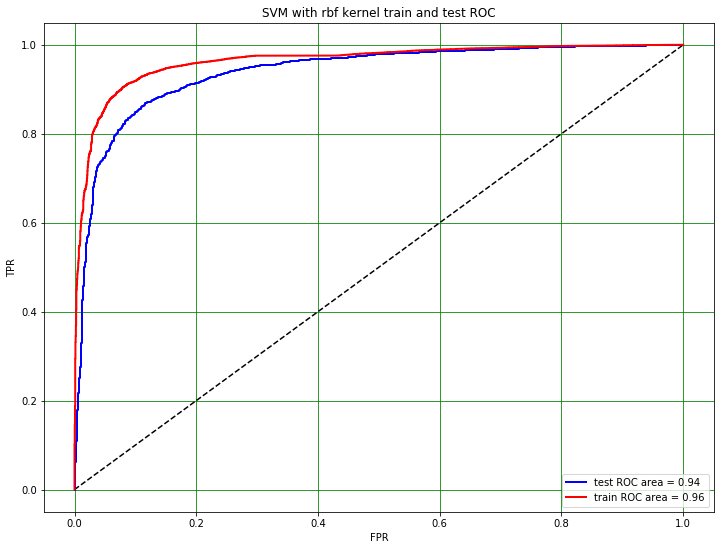

In [14]:
k = alpha[val_auc.index(max(val_auc))]
clf = SVC(C=k, kernel='rbf', class_weight='balanced',gamma='auto')
clf.fit(x_train,y_train)
test_pred_prob = clf.decision_function(x_test)

# test AUC
test_fpr, test_tpr, _ = roc_curve(y_test, test_pred_prob,pos_label = 1)
test_auc = auc(test_fpr, test_tpr)
plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('SVM with rbf kernel train and test ROC')
plt.plot(test_fpr, test_tpr, color='blue', lw=2, label='test ROC area = %0.2f' % test_auc)
plt.plot(train_fpr[k], train_tpr[k], color='red', lw=2, label='train ROC area = %0.2f' % train_auc[alpha.index(k)])
plt.legend(loc="lower right")
plt.show()

### Train confusion matrix

In [15]:
train_pred = clf.predict(x_train)
conf_matrix = confusion_matrix(y_train, train_pred)
report = classification_report(y_train, train_pred)
print("report\n",report)
 

report
               precision    recall  f1-score   support

           0       0.50      0.94      0.65      2646
           1       0.99      0.88      0.93     21354

   micro avg       0.89      0.89      0.89     24000
   macro avg       0.75      0.91      0.79     24000
weighted avg       0.94      0.89      0.90     24000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

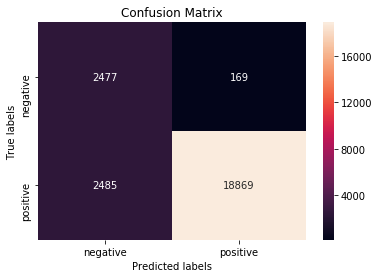

In [16]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

### test confusion matrix

In [17]:
test_pred = clf.predict(x_test)
conf_matrix = confusion_matrix(y_test, test_pred)
report = classification_report(y_test, test_pred)
print("report\n",report)

report
               precision    recall  f1-score   support

           0       0.51      0.87      0.64      1040
           1       0.98      0.87      0.92      6960

   micro avg       0.87      0.87      0.87      8000
   macro avg       0.74      0.87      0.78      8000
weighted avg       0.92      0.87      0.89      8000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

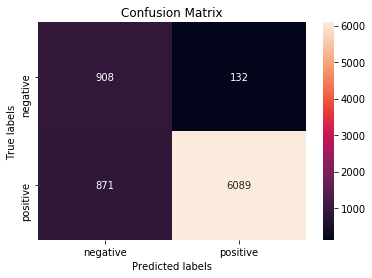

In [18]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

In [26]:
with open("amazon-fine-food-reviews/X_train.pkl","rb") as file:
  X_train = pickle.load(file)
  
with open("amazon-fine-food-reviews/X_test.pkl","rb") as file:
  X_test = pickle.load(file)

with open("amazon-fine-food-reviews/X_val.pkl","rb") as file:
  X_val = pickle.load(file)

In [27]:
tf_idf_model = TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=500)
x_train = tf_idf_model.fit_transform(X_train.values[:24000])
x_val = tf_idf_model.transform(X_val.values[:8000])
x_test = tf_idf_model.transform(X_test.values[:8000])

In [28]:
with open("amazon-fine-food-reviews/X_train_summary.pkl","rb") as file:
  X_train_summary = pickle.load(file)
  
with open("amazon-fine-food-reviews/X_test_summary.pkl","rb") as file:
  X_test_summary = pickle.load(file)

with open("amazon-fine-food-reviews/X_val_summary.pkl","rb") as file:
  X_val_summary = pickle.load(file)

In [29]:
tf_idf_model = TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=500)
x_train_summary = tf_idf_model.fit_transform(X_train_summary.values[:24000])
x_val_summary = tf_idf_model.transform(X_val_summary.values[:8000])
x_test_summary = tf_idf_model.transform(X_test_summary.values[:8000])

In [30]:
# read TFIDF vectors stored in pickle file and related lables
with open("amazon-fine-food-reviews/y_train.pkl","rb") as file:
  y_train = pickle.load(file)
  y_train = [1 if x=='positive' else 0 for x in y_train[:24000]]
with open("amazon-fine-food-reviews/y_test.pkl","rb") as file:
  y_test = pickle.load(file)
  y_test = [1 if x=='positive' else 0 for x in y_test[:8000]]
with open("amazon-fine-food-reviews/y_val.pkl","rb") as file:
  y_val = pickle.load(file)  
  y_val = [1 if x=='positive' else 0 for x in y_val[:8000]]

In [31]:
# merge text and summary vectors
x_train = hstack([x_train, x_train_summary])
x_val = hstack([x_val, x_val_summary])
x_test = hstack([x_test, x_test_summary])

In [32]:
#np.arange(1e-05,1e+05,1000)
alpha = 10.**np.arange(-5, 6)
alpha = list(alpha)
alpha

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]

In [33]:
# empty list that will hold cv scores
cv_scores = []
train_fpr = dict()
train_tpr = dict()
val_fpr = dict()
val_tpr = dict()
train_auc = []
val_auc = []
# perform  cross validation
for k in tqdm(alpha):
    clf = SVC(C=k, kernel='rbf', class_weight='balanced',gamma='auto')
    clf.fit(x_train,y_train)
    #predict probabilities for train and validation    
    train_pred_prob = clf.decision_function(x_train)
    val_pred_prob = clf.decision_function(x_val)
    # train AUC
    train_fpr[k], train_tpr[k], _ = roc_curve(y_train, train_pred_prob,pos_label = 1)
    train_auc.append(auc(train_fpr[k], train_tpr[k]))
    # validation AUC
    val_fpr[k], val_tpr[k], _ = roc_curve(y_val, val_pred_prob,pos_label = 1)
    val_auc.append(auc(val_fpr[k], val_tpr[k]))

100%|██████████| 11/11 [1:11:03<00:00, 522.64s/it]


In [34]:
# finding best K with cross validation
print("K with maximum score in cross validation : {0}, max validation AUC :{1}".format(alpha[val_auc.index(max(val_auc))],max(val_auc)))


K with maximum score in cross validation : 100.0, max validation AUC :0.9486462821610016


In [35]:
# apply log function to alpha value to display on graph as these are bigger values  
print(alpha)
alp = list(map(log10,alpha)) 
print(alp)

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]
[-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


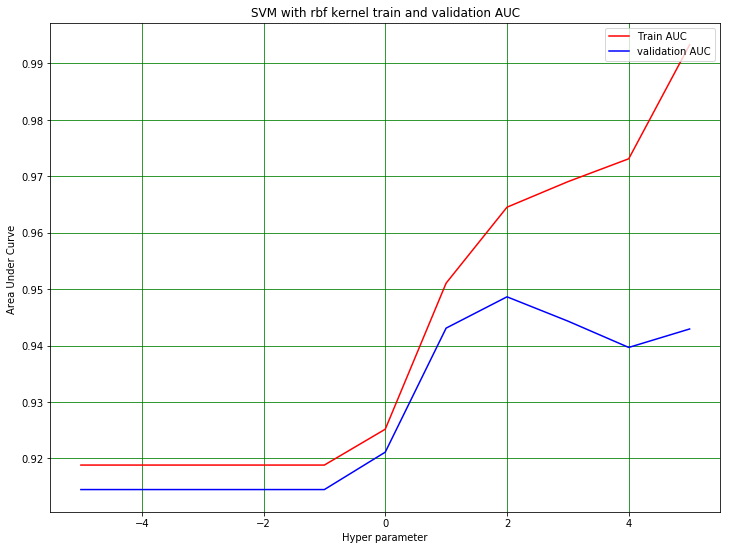

In [36]:
# AUC graph for data with extra features
plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under Curve ')
plt.title('SVM with rbf kernel train and validation AUC')
plt.plot(alp,train_auc, color='red', label='Train AUC')
plt.plot(alp,val_auc, color='blue', label='validation AUC')
plt.legend(loc="upper right")
plt.show() 

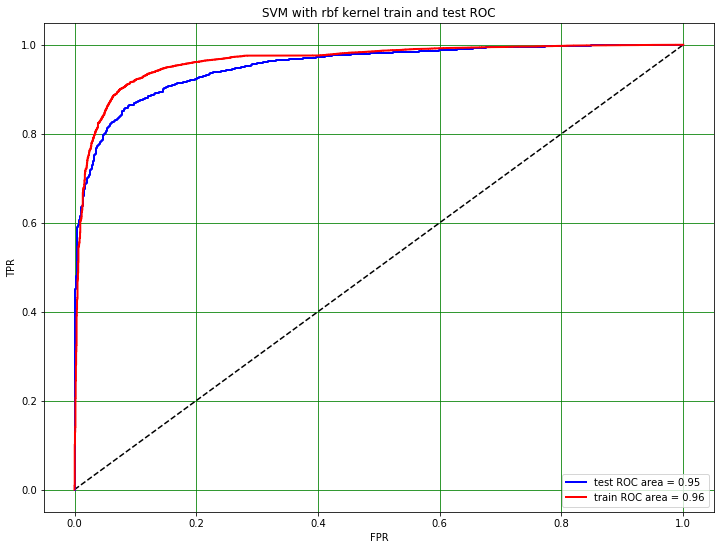

In [37]:
k = alpha[val_auc.index(max(val_auc))]
clf = SVC(C=k, kernel='rbf', class_weight='balanced',gamma='auto')
clf.fit(x_train,y_train)
test_pred_prob = clf.decision_function(x_test)

# test AUC
test_fpr, test_tpr, _ = roc_curve(y_test, test_pred_prob,pos_label = 1)
test_auc = auc(test_fpr, test_tpr)
plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('SVM with rbf kernel train and test ROC')
plt.plot(test_fpr, test_tpr, color='blue', lw=2, label='test ROC area = %0.2f' % test_auc)
plt.plot(train_fpr[k], train_tpr[k], color='red', lw=2, label='train ROC area = %0.2f' % train_auc[alpha.index(k)])
plt.legend(loc="lower right")
plt.show()

### Train confusion matrix

In [38]:
train_pred = clf.predict(x_train)
conf_matrix = confusion_matrix(y_train, train_pred)
report = classification_report(y_train, train_pred)
print("report\n",report)
 

report
               precision    recall  f1-score   support

           0       0.51      0.93      0.66      2646
           1       0.99      0.89      0.94     21354

   micro avg       0.89      0.89      0.89     24000
   macro avg       0.75      0.91      0.80     24000
weighted avg       0.94      0.89      0.91     24000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

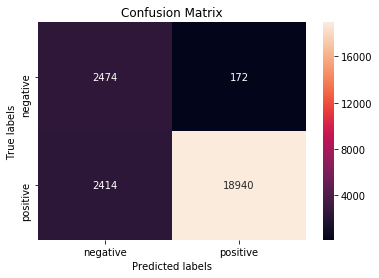

In [39]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

### test confusion matrix

In [40]:
test_pred = clf.predict(x_test)
conf_matrix = confusion_matrix(y_test, test_pred)
report = classification_report(y_test, test_pred)
print("report\n",report)

report
               precision    recall  f1-score   support

           0       0.52      0.88      0.66      1040
           1       0.98      0.88      0.93      6960

   micro avg       0.88      0.88      0.88      8000
   macro avg       0.75      0.88      0.79      8000
weighted avg       0.92      0.88      0.89      8000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

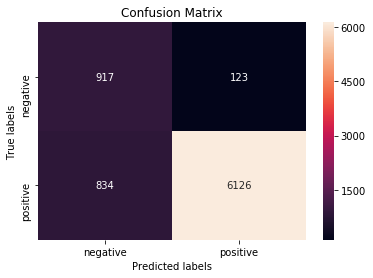

In [41]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [3]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from scipy.sparse import coo_matrix, hstack
from scipy.sparse.csr import csr_matrix
import sqlite3
import pandas as pd
from sklearn.svm import SVC
from math import log10
import pickle

In [4]:
# read vectors stored in pickle file and related lables
import pickle
with open("amazon-fine-food-reviews/avg_w2v/avg_w2v_x_train.pkl","rb") as file:
  x_train = pickle.load(file)

with open("amazon-fine-food-reviews/avg_w2v/avg_w2v_x_val.pkl","rb") as file:
  x_val = pickle.load(file)
  
with open("amazon-fine-food-reviews/avg_w2v/avg_w2v_x_test.pkl","rb") as file:
  x_test = pickle.load(file)

with open("amazon-fine-food-reviews/avg_w2v/avg_w2v_x_train_summary.pkl","rb") as file:
  train_summary = pickle.load(file)

with open("amazon-fine-food-reviews/avg_w2v/avg_w2v_x_val_summary.pkl","rb") as file:
  val_summary = pickle.load(file)
  
with open("amazon-fine-food-reviews/avg_w2v/avg_w2v_x_test_summary.pkl","rb") as file:
  test_summary = pickle.load(file)

with open("amazon-fine-food-reviews/y_train.pkl","rb") as file:
  y_train = pickle.load(file)
  y_train = [1 if x=='positive' else 0 for x in y_train[:24000]]
with open("amazon-fine-food-reviews/y_test.pkl","rb") as file:
  y_test = pickle.load(file)
  y_test = [1 if x=='positive' else 0 for x in y_test[:8000]]
with open("amazon-fine-food-reviews/y_val.pkl","rb") as file:
  y_val = pickle.load(file)  
  y_val = [1 if x=='positive' else 0 for x in y_val[:8000]]

In [5]:
# merge text and summary vectors
x_train =[np.concatenate((x,train_summary[idx])) for idx,x in enumerate(x_train[:24000])]
x_val = [np.concatenate((x,val_summary[idx])) for idx,x in enumerate(x_val[:8000])]
x_test = [np.concatenate((x,test_summary[idx])) for idx,x in enumerate(x_test[:8000])]

In [6]:
#np.arange(1e-05,1e+05,1000)
alpha = 10.**np.arange(-5, 6)
alpha = list(alpha)
alpha

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]

In [7]:
# empty list that will hold cv scores
cv_scores = []
train_fpr = dict()
train_tpr = dict()
val_fpr = dict()
val_tpr = dict()
train_auc = []
val_auc = []
# perform  cross validation
for k in tqdm(alpha):
    clf = SVC(C=k, kernel='rbf', class_weight='balanced',gamma='auto')
    clf.fit(x_train,y_train)
    #predict probabilities for train and validation    
    train_pred_prob = clf.decision_function(x_train)
    val_pred_prob = clf.decision_function(x_val)
    # train AUC
    train_fpr[k], train_tpr[k], _ = roc_curve(y_train, train_pred_prob,pos_label = 1)
    train_auc.append(auc(train_fpr[k], train_tpr[k]))
    # validation AUC
    val_fpr[k], val_tpr[k], _ = roc_curve(y_val, val_pred_prob,pos_label = 1)
    val_auc.append(auc(val_fpr[k], val_tpr[k]))

100%|██████████| 11/11 [1:10:35<00:00, 667.26s/it]


In [8]:
# finding best K with cross validation
print("K with maximum score in cross validation : {0}, max validation AUC :{1}".format(alpha[val_auc.index(max(val_auc))],max(val_auc)))


K with maximum score in cross validation : 10.0, max validation AUC :0.9416834604841352


In [9]:
# apply log function to alpha value to display on graph as these are bigger values  
print(alpha)
alp = list(map(log10,alpha)) 
print(alp)

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]
[-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


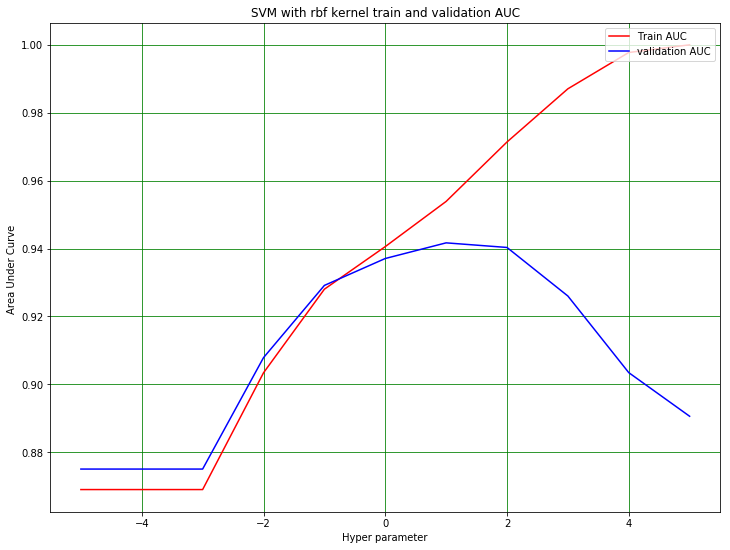

In [10]:
# AUC graph for data with extra features
plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under Curve ')
plt.title('SVM with rbf kernel train and validation AUC')
plt.plot(alp,train_auc, color='red', label='Train AUC')
plt.plot(alp,val_auc, color='blue', label='validation AUC')
plt.legend(loc="upper right")
plt.show() 

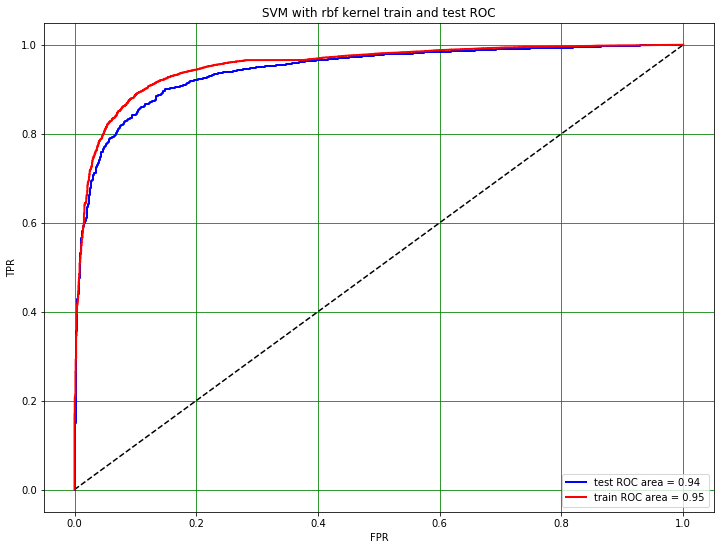

In [11]:
k = alpha[val_auc.index(max(val_auc))]
clf = SVC(C=k, kernel='rbf', class_weight='balanced',gamma='auto')
clf.fit(x_train,y_train)
test_pred_prob = clf.decision_function(x_test)

# test AUC
test_fpr, test_tpr, _ = roc_curve(y_test, test_pred_prob,pos_label = 1)
test_auc = auc(test_fpr, test_tpr)
plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('SVM with rbf kernel train and test ROC')
plt.plot(test_fpr, test_tpr, color='blue', lw=2, label='test ROC area = %0.2f' % test_auc)
plt.plot(train_fpr[k], train_tpr[k], color='red', lw=2, label='train ROC area = %0.2f' % train_auc[alpha.index(k)])
plt.legend(loc="lower right")
plt.show()

### Train confusion matrix

In [12]:
train_pred = clf.predict(x_train)
conf_matrix = confusion_matrix(y_train, train_pred)
report = classification_report(y_train, train_pred)
print("report\n",report)
 

report
               precision    recall  f1-score   support

           0       0.47      0.91      0.62      2646
           1       0.99      0.87      0.93     21354

   micro avg       0.88      0.88      0.88     24000
   macro avg       0.73      0.89      0.77     24000
weighted avg       0.93      0.88      0.89     24000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

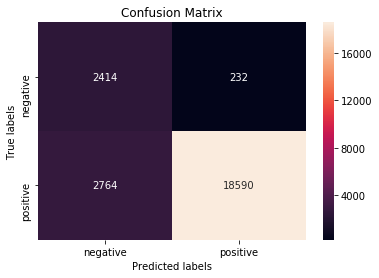

In [13]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

### test confusion matrix

In [14]:
test_pred = clf.predict(x_test)
conf_matrix = confusion_matrix(y_test, test_pred)
report = classification_report(y_test, test_pred)
print("report\n",report)

report
               precision    recall  f1-score   support

           0       0.50      0.88      0.64      1040
           1       0.98      0.87      0.92      6960

   micro avg       0.87      0.87      0.87      8000
   macro avg       0.74      0.87      0.78      8000
weighted avg       0.92      0.87      0.88      8000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

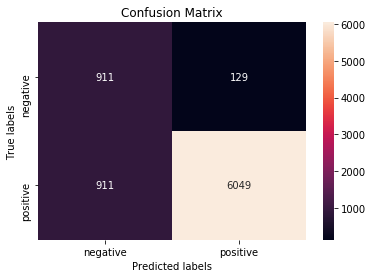

In [15]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [105]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from scipy.sparse import coo_matrix, hstack
from scipy.sparse.csr import csr_matrix
import sqlite3
import pandas as pd
from sklearn.svm import SVC
from math import log10
import pickle

In [106]:
import pickle
with open("amazon-fine-food-reviews/tfidf_w2v/tfidf_w2v_x_train.pkl","rb") as file:
  x_train = pickle.load(file)

with open("amazon-fine-food-reviews/tfidf_w2v/tfidf_w2v_x_val.pkl","rb") as file:
  x_val = pickle.load(file)
  
with open("amazon-fine-food-reviews/tfidf_w2v/tfidf_w2v_x_test.pkl","rb") as file:
  x_test = pickle.load(file)

with open("amazon-fine-food-reviews/tfidf_w2v/tfidf_w2v_x_train_summary.pkl","rb") as file:
  train_summary = pickle.load(file)

with open("amazon-fine-food-reviews/tfidf_w2v/tfidf_w2v_x_val_summary.pkl","rb") as file:
  val_summary = pickle.load(file)
  
with open("amazon-fine-food-reviews/tfidf_w2v/tfidf_w2v_x_test_summary.pkl","rb") as file:
  test_summary = pickle.load(file)

with open("amazon-fine-food-reviews/y_train.pkl","rb") as file:
  y_train = pickle.load(file)
  y_train = [1 if x=='positive' else 0 for x in y_train[:24000]]
with open("amazon-fine-food-reviews/y_test.pkl","rb") as file:
  y_test = pickle.load(file)
  y_test = [1 if x=='positive' else 0 for x in y_test[:8000]]
with open("amazon-fine-food-reviews/y_val.pkl","rb") as file:
  y_val = pickle.load(file)  
  y_val = [1 if x=='positive' else 0 for x in y_val[:8000]]

In [107]:
# merge text and summary vectors
x_train =[np.concatenate((x,train_summary[idx])) for idx,x in enumerate(x_train[:24000])]
x_val = [np.concatenate((x,val_summary[idx])) for idx,x in enumerate(x_val[:8000])]
x_test = [np.concatenate((x,test_summary[idx])) for idx,x in enumerate(x_test[:8000])]

In [108]:
#np.arange(1e-05,1e+05,1000)
alpha = 10.**np.arange(-5, 6)
alpha = list(alpha)
alpha

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]

In [109]:
# empty list that will hold cv scores
cv_scores = []
train_fpr = dict()
train_tpr = dict()
val_fpr = dict()
val_tpr = dict()
train_auc = []
val_auc = []
# perform  cross validation
for k in tqdm(alpha):
    clf = SVC(C=k, kernel='rbf', class_weight='balanced',gamma='auto')
    clf.fit(x_train,y_train)
    #predict probabilities for train and validation    
    train_pred_prob = clf.decision_function(x_train)
    val_pred_prob = clf.decision_function(x_val)
    # train AUC
    train_fpr[k], train_tpr[k], _ = roc_curve(y_train, train_pred_prob,pos_label = 1)
    train_auc.append(auc(train_fpr[k], train_tpr[k]))
    # validation AUC
    val_fpr[k], val_tpr[k], _ = roc_curve(y_val, val_pred_prob,pos_label = 1)
    val_auc.append(auc(val_fpr[k], val_tpr[k]))

100%|██████████| 11/11 [1:16:24<00:00, 707.34s/it]


In [110]:
# finding best K with cross validation
print("K with maximum score in cross validation : {0}, max validation AUC :{1}".format(alpha[val_auc.index(max(val_auc))],max(val_auc)))


K with maximum score in cross validation : 10.0, max validation AUC :0.9278546158341554


In [111]:
# apply log function to alpha value to display on graph as these are bigger values  
print(alpha)
alp = list(map(log10,alpha)) 
print(alp)

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]
[-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


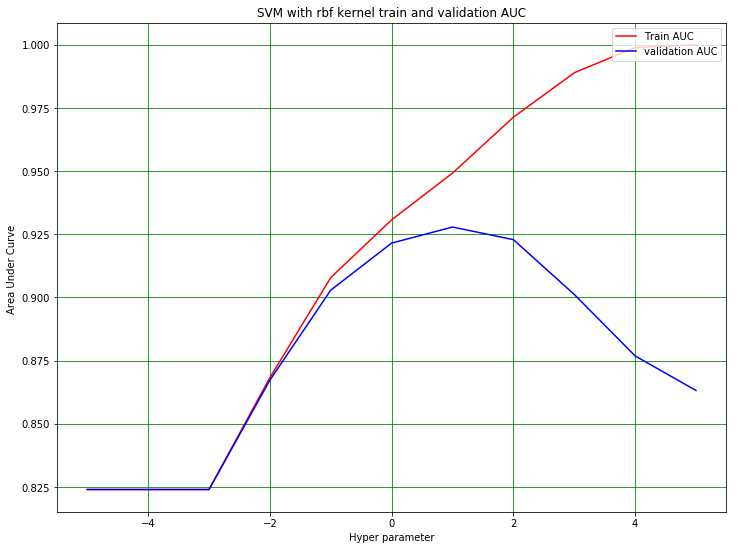

In [112]:
# AUC graph for data with extra features
plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under Curve ')
plt.title('SVM with rbf kernel train and validation AUC')
plt.plot(alp,train_auc, color='red', label='Train AUC')
plt.plot(alp,val_auc, color='blue', label='validation AUC')
plt.legend(loc="upper right")
plt.show() 

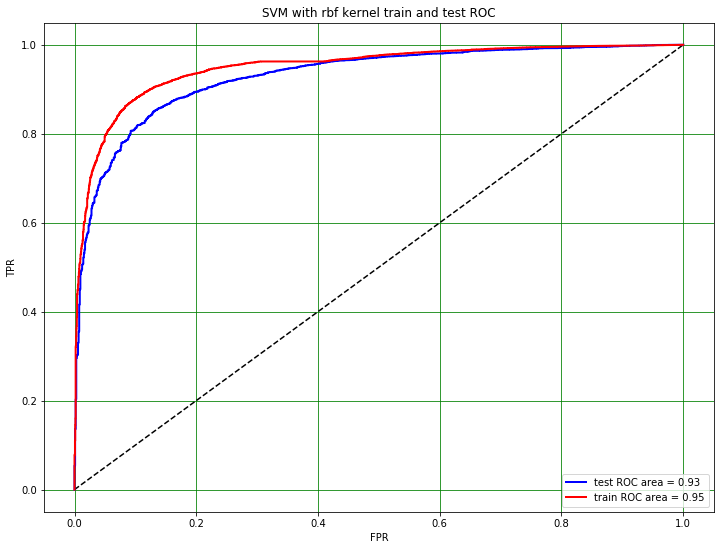

In [113]:
k = alpha[val_auc.index(max(val_auc))]
clf =  SVC(C=k, kernel='rbf', class_weight='balanced',gamma='auto')
clf.fit(x_train,y_train)
test_pred_prob = clf.decision_function(x_test)

# test AUC
test_fpr, test_tpr, _ = roc_curve(y_test, test_pred_prob,pos_label = 1)
test_auc = auc(test_fpr, test_tpr)
plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('SVM with rbf kernel train and test ROC')
plt.plot(test_fpr, test_tpr, color='blue', lw=2, label='test ROC area = %0.2f' % test_auc)
plt.plot(train_fpr[k], train_tpr[k], color='red', lw=2, label='train ROC area = %0.2f' % train_auc[alpha.index(k)])
plt.legend(loc="lower right")
plt.show()

### Train confusion matrix

In [114]:
train_pred = clf.predict(x_train)
conf_matrix = confusion_matrix(y_train, train_pred)
report = classification_report(y_train, train_pred)
print("report\n",report)
 

report
               precision    recall  f1-score   support

           0       0.44      0.92      0.60      2646
           1       0.99      0.86      0.92     21354

   micro avg       0.86      0.86      0.86     24000
   macro avg       0.72      0.89      0.76     24000
weighted avg       0.93      0.86      0.88     24000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

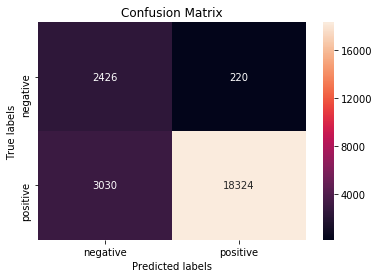

In [115]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

### test confusion matrix

In [116]:
test_pred = clf.predict(x_test)
conf_matrix = confusion_matrix(y_test, test_pred)
report = classification_report(y_test, test_pred)
print("report\n",report)

report
               precision    recall  f1-score   support

           0       0.46      0.87      0.61      1040
           1       0.98      0.85      0.91      6960

   micro avg       0.85      0.85      0.85      8000
   macro avg       0.72      0.86      0.76      8000
weighted avg       0.91      0.85      0.87      8000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

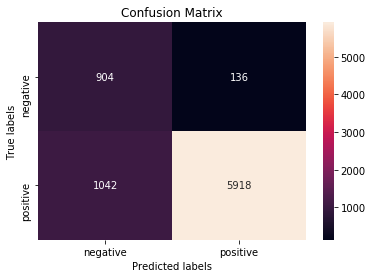

In [117]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

# [6] Conclusions

In [96]:
from prettytable import PrettyTable

In [104]:
pt = PrettyTable()
pt.field_names = ["Vectorizer", "Model","Regularizer","Kernel","Summary as feature","Hyper Parameter", "AUC"]
pt.add_row(["BOW", "SVM","L1","linear", "YES", 1e-05,0.94])
pt.add_row(["BOW", "SVM","L2","linear", "YES", 0.001,0.96])
pt.add_row(["TFIDF","SVM","L1","linear", "YES",1e-05,0.97])
pt.add_row(["TFIDF","SVM","L2","linear", "YES",1e-05,0.98])
pt.add_row(["AVG W2V","SVM","L2","linear", "YES",0.0001,0.94])
pt.add_row(["TFIDF W2V","SVM","L2","linear", "YES",0.0001,0.92 ])
pt.add_row(["BOW", "SVM","-","RBF", "YES", 10.0,0.94])
pt.add_row(["TFIDF","SVM","-","RBF", "YES",100.0,0.95])
pt.add_row(["AVG W2V","SVM","-","RBF", "YES",10.0,0.94])
pt.add_row(["TFIDF W2V","SVM","-","RBF", "YES",10.0,0.93]) 
print(pt)

+------------+-------+-------------+--------+--------------------+-----------------+------+
| Vectorizer | Model | Regularizer | Kernel | Summary as feature | Hyper Parameter | AUC  |
+------------+-------+-------------+--------+--------------------+-----------------+------+
|    BOW     |  SVM  |      L1     | linear |        YES         |      1e-05      | 0.94 |
|    BOW     |  SVM  |      L2     | linear |        YES         |      0.001      | 0.96 |
|   TFIDF    |  SVM  |      L1     | linear |        YES         |      1e-05      | 0.97 |
|   TFIDF    |  SVM  |      L2     | linear |        YES         |      1e-05      | 0.98 |
|  AVG W2V   |  SVM  |      L2     | linear |        YES         |      0.0001     | 0.94 |
| TFIDF W2V  |  SVM  |      L2     | linear |        YES         |      0.0001     | 0.92 |
|    BOW     |  SVM  |      -      |  RBF   |        YES         |       10.0      | 0.94 |
|   TFIDF    |  SVM  |      -      |  RBF   |        YES         |      100.0   

Observation:<br>
    Linear SVM with TFIDF vectorizer and L2 regularizer have better F1 scores for both negative and positive class(0.80 and 0.97 respectively). 